Google Earth Engine
---

In [474]:
import ee
ee.Authenticate()
ee.Initialize()

In [473]:
import numpy as np
from matplotlib import pyplot as plt

(np.array([48,74])-32)*5/9

array([ 8.88888889, 23.33333333])

In [475]:
import folium

era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate('2024-09-18', '2024-09-30')
temp_data = era5.select('temperature_2m')
temperature = temp_data.mean().subtract(273.15)


# Define visualization parameters
vis_params = {
    'min': 8.5,
    'max': 23.5,
    'palette': ['blue', 'green', 'yellow', 'red']
}

# Create a map centered around Ashfield
map_center = [42.500,	-72.76800]
m = folium.Map(location=map_center, zoom_start=10)

# Add the temperature layer to the map using the folium and Earth Engine integration
folium.TileLayer(
    tiles=temperature.getMapId(vis_params)['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    opacity=0.6
).add_to(m)

# Display the map
m

---

save as a GeoTIFF
---

In [198]:
list(reversed(map_center))

[-72.768, 42.5]

In [200]:
center_point = ee.Geometry.Point(list(reversed(map_center)))
region_of_interest = center_point.buffer(30000) #meters

#era5 defined above
# era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate('2024-09-18', '2024-09-30')

temperature_image = era5.select('temperature_2m').mean().subtract(273.15) #centigrapes

task = ee.batch.Export.image.toDrive(
    image=temperature_image,
    description='ERA5_temperature_export_NWMass_native_resolution_31kmpp_reversedmapcenter',
    region = region_of_interest,
    scale = 9000, #native era5 resolution
    fileFormat='GeoTIFF'
)

task.start()

print('done. go to the google earth engine code editor and look at tasks to download from goodle drive')

done. go to the google earth engine code editor and look at tasks to download from goodle drive


In [196]:
era5.select

In [201]:
#reversed map coordinates
import rasterio
tiff_file = '../weather-data/era5/ERA5_temperature_export_NWMass_native_resolution_31kmpp_reversedmapcenter.tif'

with rasterio.open(tiff_file) as src:
    src_data = src.read()
    temperature_data = src.read(1)

print(temperature_data.shape)

(8, 10)


In [63]:
# #normal map coordinates
# import rasterio
# tiff_file = '../weather-data/era5/ERA5_temperature_export_NWMass_native_resolution_9kmpp.tif'

# with rasterio.open(tiff_file) as src:
#     src_data = src.read()
#     temperature_data = src.read(1)

# print(temperature_data.shape)

(8, 23)


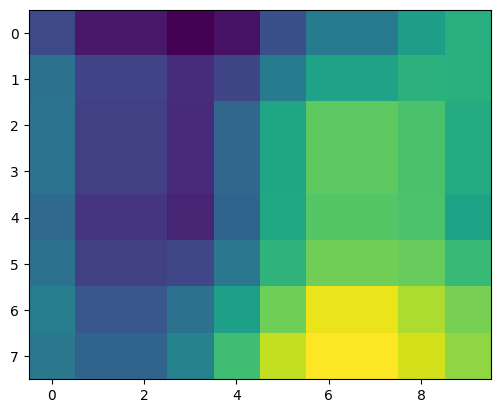

In [219]:
plt.imshow(temperature_data)

now incorporate different times rather than the mean over the period Sept 18-30
---

In [205]:
#reversed map coordinates
era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate('2024-09-18', '2024-09-30')

def accumulate_bands(image, previous):
    image = image.select('temperature_2m').toFloat()
    return ee.Image(previous).addBands(image)

initial_image = ee.Image().toFloat()

composite_image = ee.Image(era5.iterate(accumulate_bands, initial_image))

# Export the composite image to Google Drive
task = ee.batch.Export.image.toDrive(
    image=composite_image,
    description='ERA5_Temperature_TimeSeries_NWMass_native_31km_reversedmapcoordinates',
    region=region_of_interest,
    scale=9000,  # Use native resolution for ERA5
    fileFormat='GeoTIFF'
)
task.start()

print('done')


#normal map coordinates
# era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate('2024-09-18', '2024-09-30')

# def accumulate_bands(image, previous):
#     image = image.select('temperature_2m').toFloat()
#     return ee.Image(previous).addBands(image)

# initial_image = ee.Image().toFloat()

# composite_image = ee.Image(era5.iterate(accumulate_bands, initial_image))

# # Export the composite image to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=composite_image,
#     description='ERA5_Temperature_TimeSeries_NWMass_native',
#     region=region_of_interest,
#     scale=9000,  # Use native resolution for ERA5
#     fileFormat='GeoTIFF'
# )
# task.start()

# print('done')

done


In [221]:

tiff_file = '../weather-data/era5/ERA5_Temperature_TimeSeries_NWMass_native_31km_reversedmapcoordinates.tif'

with rasterio.open(tiff_file) as src:
    src_data = src.read()
    # temperature_data = src.read(1)

print(src_data.shape)


#normal coordinates
# tiff_file = '../weather-data/era5/ERA5_Temperature_TimeSeries_NWMass_native.tif'

# with rasterio.open(tiff_file) as src:
#     src_data = src.read()
#     # temperature_data = src.read(1)

# print(src_data.shape)

(169, 8, 10)


In [261]:
start = pd.to_datetime('2024-09-18')
end = pd.to_datetime('2024-09-25')
dates = pd.date_range(start=start,end=end,freq='h')[1:]

len(dates)

168

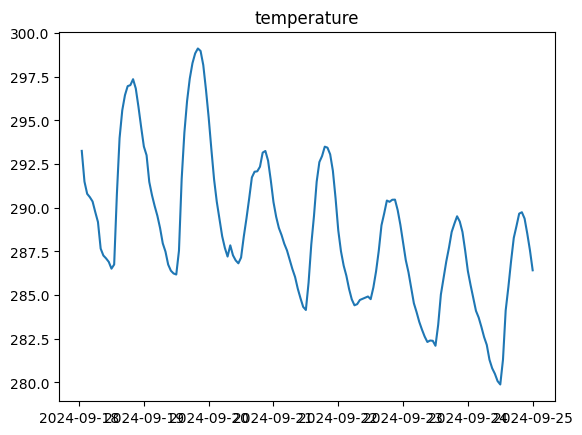

In [264]:
#src_data is a  numpy array with shape (169 hours, 8 rows (latitude), 23 cols (longitude))
#not sure why the values are so low. Shouldn't it be ~300 K? What.

#regardless of the unit, the best matching spot should correlate.

#create a temperature series from sept18 to sept30 for each square by inverting the numpy array
temp_series = src_data[1:].T

#plot a couple
import pandas as pd
start = pd.to_datetime('2024-09-18')
end = pd.to_datetime('2024-09-25') #169 results means only 7 days elapsed in the data. It may be a week old is all.
dates = pd.date_range(start=start,end=end,freq='h')[1:] #cut off the first because it was nan

plt.plot(dates, temp_series[0,0])
plt.title('temperature');

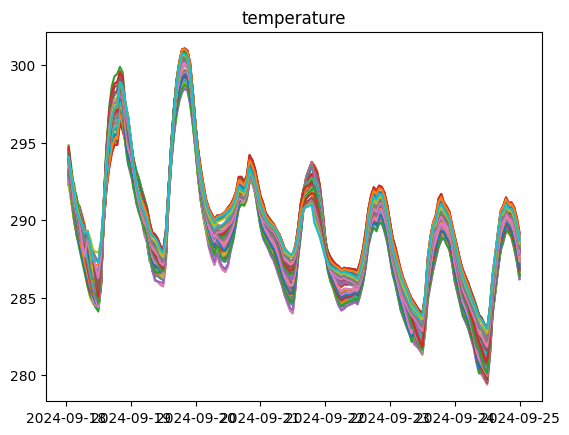

In [224]:
for temp_serie in temp_series.reshape((-1,168)):
    plt.plot(dates, temp_serie)
plt.title('temperature');
plt.show()

In [225]:
era5_temps.index

RangeIndex(start=0, stop=80, step=1, name='square')

<Axes: xlabel='square'>

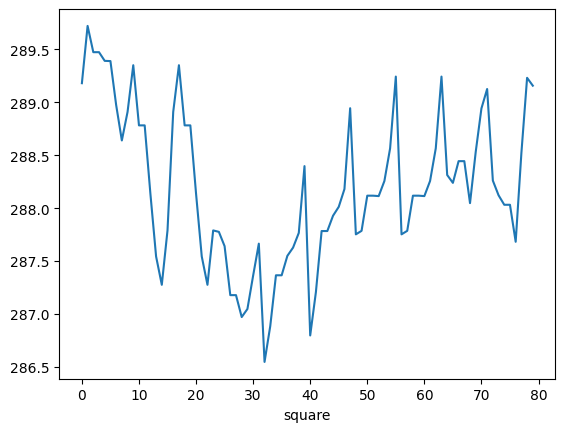

In [420]:
era5_temps[era5_temps.columns[6]].plot()

In [472]:
np.array([[1,2,3],[4,5,6],[7,8,9]]).reshape((-1,9))

array([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [461]:
#let's make temp_series a dataframe for easier plotting and adding the live feed temperatures.
era5_temps = pd.DataFrame(temp_series.reshape((-1,168)), columns = dates) #make each entry a series for a different square.

era5_temps['row'] = era5_temps.index // 10
era5_temps['col'] = era5_temps.index % 10

era5_temps.index.name = 'square'

era5_temps.info()
era5_temps.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Columns: 170 entries, 2024-09-18 01:00:00 to col
dtypes: float32(168), int64(2)
memory usage: 53.9 KB


,2024-09-18 01:00:00,2024-09-18 02:00:00,2024-09-18 03:00:00,2024-09-18 04:00:00,2024-09-18 05:00:00,2024-09-18 06:00:00,2024-09-18 07:00:00,2024-09-18 08:00:00,2024-09-18 09:00:00,2024-09-18 10:00:00,...,2024-09-24 17:00:00,2024-09-24 18:00:00,2024-09-24 19:00:00,2024-09-24 20:00:00,2024-09-24 21:00:00,2024-09-24 22:00:00,2024-09-24 23:00:00,2024-09-25 00:00:00,row,col
square,,,,,,,,,,,,,,,,,,,,,
0,293.252777,291.494202,290.795929,290.603638,290.357544,289.751709,289.180359,287.658997,287.265289,287.099640,...,288.273254,288.949097,289.661743,289.741669,289.381348,288.515564,287.553589,286.418579,0,0
1,293.340668,292.078186,291.534210,291.132935,290.966919,290.314209,289.721375,288.201965,287.689117,287.285187,...,288.542786,289.197144,289.927368,289.886200,289.541504,288.726501,287.842651,286.754517,0,1
2,292.994965,292.343811,291.782257,290.968872,290.863403,290.212646,289.473328,287.858215,287.099274,286.339874,...,288.652161,289.288940,290.030884,289.876434,289.549316,288.794861,287.996948,286.949829,0,2
3,292.994965,292.343811,291.782257,290.968872,290.863403,290.212646,289.473328,287.858215,287.099274,286.339874,...,288.652161,289.288940,290.030884,289.876434,289.549316,288.794861,287.996948,286.949829,0,3
4,292.700043,292.113342,291.245148,290.230591,290.170044,289.972412,289.391296,287.905090,286.915680,285.732452,...,288.531067,289.152222,289.890259,289.747528,289.434082,288.728455,287.994995,286.986938,0,4


In [462]:
#index by row, col
era5_temps_by_square = era5_temps.set_index(['row','col'])
era5_temps_by_square

2024-09-18 01:00:00  2024-09-18 02:00:00  2024-09-18 03:00:00  \
row col                                                                  
0   0             293.252777           291.494202           290.795929   
    1             293.340668           292.078186           291.534210   
    2             292.994965           292.343811           291.782257   
    3             292.994965           292.343811           291.782257   
    4             292.700043           292.113342           291.245148   
...                      ...                  ...                  ...   
9   3             294.377777           292.543030           291.889679   
    4             293.719574           292.521545           291.368195   
    5             293.840668           292.865295           291.893585   
    6             294.026215           292.998108           291.961945   
    7             294.090668           292.794983           291.672882   

         2024-09-18 04:00:00  2024-09-18 05:00:00  2024-09-18 06:00:00  \
row col                                                                  
0   0             290.603638           290.357544           289.751709   
    1             291.132935           290.966919           290.314209   
    2             290.968872           290.863403           290.212646   
    3             290.968872           290.863403           290.212646   
    4             290.230591           290.170044           289.972412   
...                      ...                  ...                  ...   
9   3             290.691528           289.496216           288.552490   
    4             290.728638           289.808716           288.511475   
    5             290.921997           290.144653           289.460693   
    6             290.865356           290.191528           289.743896   
    7             290.623169           290.074341           289.718506   

         2024-09-18 07:00:00  2024-09-18 08:00:00  2024-09-18 09:00:00  \
row col                                                                  
0   0             289.180359           287.658997           287.265289   
    1             289.721375           288.201965           287.689117   
    2             289.473328           287.858215           287.099274   
    3             289.473328           287.858215           287.099274   
    4             289.391296           287.905090           286.915680   
...                      ...                  ...                  ...   
9   3             288.031921           288.926575           288.489899   
    4             287.682312           288.840637           288.370758   
    5             288.520203           289.035950           288.556305   
    6             289.231140           289.283997           288.849274   
    7             289.156921           289.235168           288.521149   

         2024-09-18 10:00:00  ...  2024-09-24 15:00:00  2024-09-24 16:00:00  \
row col                       ...                                             
0   0             287.099640  ...           285.457275           286.941559   
    1             287.285187  ...           285.715088           287.199371   
    2             286.339874  ...           285.814697           287.300934   
    3             286.339874  ...           285.814697           287.300934   
    4             285.732452  ...           285.765869           287.201324   
...                      ...  ...                  ...                  ...   
9   3             287.716827  ...           287.123291           288.779449   
    4             287.878937  ...           286.994385           288.611481   
    5             288.011749  ...           287.207275           288.771637   
    6             288.121124  ...           287.539307           289.015778   
    7             287.410187  ...           287.773682           289.117340   

         2024-09-24 17:00:00  2024-09-24 18:00:00  2024-09-24 19:00:00  \
row col           

In [463]:
#index by date
era5_temps_by_date = era5_temps.T.drop(['row','col'])
era5_temps_by_date

square,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
2024-09-18 01:00:00,293.252777,293.340668,292.994965,292.994965,292.700043,292.875824,293.326996,293.059418,292.873871,292.848480,...,293.909027,294.018402,294.826996,294.723480,294.377777,294.377777,293.719574,293.840668,294.026215,294.090668
2024-09-18 02:00:00,291.494202,292.078186,292.343811,292.343811,292.113342,291.951233,291.679749,291.828186,291.369202,291.871155,...,293.017639,292.925842,293.406311,293.072327,292.543030,292.543030,292.521545,292.865295,292.998108,292.794983
2024-09-18 03:00:00,290.795929,291.534210,291.782257,291.782257,291.245148,290.559601,290.372101,290.909210,291.342804,292.122101,...,292.026398,291.823273,292.055695,291.745148,291.889679,291.889679,291.368195,291.893585,291.961945,291.672882
2024-09-18 04:00:00,290.603638,291.132935,290.968872,290.968872,290.230591,289.666138,289.209106,289.732544,290.730591,291.373169,...,290.988403,290.802856,291.502075,290.789185,290.691528,290.691528,290.728638,290.921997,290.865356,290.623169
2024-09-18 05:00:00,290.357544,290.966919,290.863403,290.863403,290.170044,289.584106,289.064575,288.824341,290.220825,290.742310,...,290.289185,290.195435,289.767700,289.527466,289.496216,289.496216,289.808716,290.144653,290.191528,290.074341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24 20:00:00,289.741669,289.886200,289.876434,289.876434,289.747528,289.784637,289.866669,289.685028,289.384247,289.380341,...,290.831512,291.052216,290.602997,290.495575,290.290497,290.290497,290.134247,290.331512,290.606903,290.761200
2024-09-24 21:00:00,289.381348,289.541504,289.549316,289.549316,289.434082,289.492676,289.609863,289.514160,289.043457,289.072754,...,290.811035,291.057129,290.406738,290.328613,290.152832,290.152832,290.029785,290.258301,290.551270,290.730957
2024-09-24 22:00:00,288.515564,288.726501,288.794861,288.794861,288.728455,288.841736,289.009705,288.945251,288.249939,288.330017,...,290.468689,290.705017,289.978455,289.917908,289.755798,289.755798,289.656189,289.890564,290.171814,290.335876
2024-09-24 23:00:00,287.553589,287.842651,287.996948,287.996948,287.994995,288.161011,288.377808,288.346558,287.340698,287.504761,...,289.784058,290.020386,289.153198,289.125854,288.994995,288.994995,288.912964,289.161011,289.475464,289.647339


In [464]:
#get the live feed data to compare
live_feed_datapath = '../weather-data/tesseract/live_view_inted.csv'
live_feed_temps = pd.read_csv(live_feed_datapath)

#get the dates of the photos
photo_datapath = '../photos/live_image_df.csv'
photo_df = pd.read_csv(photo_datapath)

In [465]:
#set the index of the temperature from the live feed to the date
live_feed_dates = pd.to_datetime(photo_df['date'])
live_feed_temps['date'] = live_feed_dates
live_feed_temps.set_index('date', inplace=True)

In [466]:
#interpolate the hourly data to every 15 mins.
era5_temps_by_date.index = pd.to_datetime(era5_temps_by_date.index) #set the index to datetime type
era5_15min = era5_temps_by_date.resample('15min').interpolate()

In [467]:
import datetime as dt

onehour = dt.timedelta(hours=1)

In [468]:
live_feed_temps.index + onehour

DatetimeIndex(['2024-09-17 20:30:00', '2024-09-17 20:45:00',
               '2024-09-17 21:00:00', '2024-09-17 21:15:00',
               '2024-09-17 21:30:00', '2024-09-17 21:45:00',
               '2024-09-17 22:00:00', '2024-09-17 22:15:00',
               '2024-09-17 22:30:00', '2024-09-17 22:45:00',
               ...
               '2024-09-29 12:00:43', '2024-09-29 12:00:44',
               '2024-09-29 12:00:45', '2024-09-29 12:15:00',
               '2024-09-29 12:30:00', '2024-09-29 12:45:00',
               '2024-09-29 13:00:00', '2024-09-29 13:01:49',
               '2024-09-29 13:15:00', '2024-09-29 13:30:00'],
              dtype='datetime64[ns]', name='date', length=1227, freq=None)

In [459]:
era5_15min

square,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
2024-09-18 01:00:00,293.252777,293.340668,292.994965,292.994965,292.700043,292.875824,293.326996,293.059418,292.873871,292.848480,...,293.909027,294.018402,294.826996,294.723480,294.377777,294.377777,293.719574,293.840668,294.026215,294.090668
2024-09-18 01:15:00,292.813133,293.025047,292.832176,292.832176,292.553368,292.644676,292.915184,292.751610,292.497704,292.604149,...,293.686180,293.745262,294.471825,294.310692,293.919090,293.919090,293.420067,293.596825,293.769188,293.766747
2024-09-18 01:30:00,292.373489,292.709427,292.669388,292.669388,292.406693,292.413528,292.503372,292.443802,292.121536,292.359818,...,293.463333,293.472122,294.116653,293.897903,293.460403,293.460403,293.120560,293.352982,293.512161,293.442825
2024-09-18 01:45:00,291.933846,292.393806,292.506599,292.506599,292.260017,292.182381,292.091560,292.135994,291.745369,292.115486,...,293.240486,293.198982,293.761482,293.485115,293.001717,293.001717,292.821053,293.109138,293.255135,293.118904
2024-09-18 02:00:00,291.494202,292.078186,292.343811,292.343811,292.113342,291.951233,291.679749,291.828186,291.369202,291.871155,...,293.017639,292.925842,293.406311,293.072327,292.543030,292.543030,292.521545,292.865295,292.998108,292.794983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24 23:00:00,287.553589,287.842651,287.996948,287.996948,287.994995,288.161011,288.377808,288.346558,287.340698,287.504761,...,289.784058,290.020386,289.153198,289.125854,288.994995,288.994995,288.912964,289.161011,289.475464,289.647339
2024-09-24 23:15:00,287.269836,287.570618,287.735168,287.735168,287.742981,287.919250,288.147278,288.132141,287.058899,287.235168,...,289.531067,289.770813,288.874329,288.852844,288.729309,288.729309,288.655579,288.908508,289.229797,289.404114
2024-09-24 23:30:00,286.986084,287.298584,287.473389,287.473389,287.490967,287.677490,287.916748,287.917725,286.777100,286.965576,...,289.278076,289.521240,288.595459,288.579834,288.463623,288.463623,288.398193,288.656006,288.984131,289.160889
2024-09-24 23:45:00,286.702332,287.026550,287.211609,287.211609,287.238953,287.435730,287.686218,287.703308,286.495300,286.695984,...,289.025085,289.271667,288.316589,288.306824,288.197937,288.197937,288.140808,288.403503,288.738464,288.917664


In [384]:
#all temperatures! Integer rows are squares in the GeoTIFF. 'temp' is the live feed temperature.
#indexed by datetime

#translate to align the times. the era5 is probably UTC, +5 hours from the live feed
live_feed_temps_translated = live_feed_temps.copy()
live_feed_temps_translated.index = live_feed_temps_translated.index + 5*onehour

temps_df = era5_15min.join(live_feed_temps_translated)

#for each column, normalize.
temps_df_norm = temps_df.copy()
for column in temps_df.columns:
    temps_df_norm[column] = temps_df[column] - temps_df[column].mean() #subtract mean
    temps_df_norm[column] = temps_df_norm[column] / temps_df_norm[column].max()
    

#get correlations
corrs = temps_df_norm.corr()['temp'].sort_values(ascending = False)
best_corrs = corrs[1:16]
best_corrs

47    0.924208
39    0.924073
63    0.921412
55    0.921412
62    0.921408
54    0.921408
46    0.920389
31    0.920201
38    0.919472
61    0.919386
53    0.919386
69    0.918399
71    0.918197
70    0.917540
45    0.917511
Name: temp, dtype: float64

In [385]:
era5_temps.loc[best_corrs.index]

,2024-09-18 01:00:00,2024-09-18 02:00:00,2024-09-18 03:00:00,2024-09-18 04:00:00,2024-09-18 05:00:00,2024-09-18 06:00:00,2024-09-18 07:00:00,2024-09-18 08:00:00,2024-09-18 09:00:00,2024-09-18 10:00:00,...,2024-09-24 17:00:00,2024-09-24 18:00:00,2024-09-24 19:00:00,2024-09-24 20:00:00,2024-09-24 21:00:00,2024-09-24 22:00:00,2024-09-24 23:00:00,2024-09-25 00:00:00,row,col
47,293.946136,292.980530,291.954132,290.966919,290.400513,289.749756,288.944031,288.276184,287.112946,286.628937,...,290.202942,290.646362,291.187134,290.819794,290.832520,290.499939,289.852417,288.889282,4,7
39,293.619965,292.628967,291.577179,290.625122,289.877075,289.083740,288.397156,287.366028,286.538727,286.177765,...,289.544739,290.056519,290.628540,290.274872,290.240723,289.849548,289.231323,288.303345,3,9
63,293.993011,293.023499,291.940460,290.951294,290.353638,289.829834,289.242859,289.157043,287.759430,286.906281,...,290.599426,290.964722,291.478149,291.120575,291.152832,290.843689,290.172729,289.184204,6,3
55,293.993011,293.023499,291.940460,290.951294,290.353638,289.829834,289.242859,289.157043,287.759430,286.906281,...,290.599426,290.964722,291.478149,291.120575,291.152832,290.843689,290.172729,289.184204,5,5
62,294.178558,293.023499,292.116241,291.037231,290.261841,289.288818,288.565125,289.323059,288.277008,286.193390,...,290.534973,290.859253,291.421509,291.026825,291.033691,290.728455,290.055542,289.024048,6,2
54,294.178558,293.023499,292.116241,291.037231,290.261841,289.288818,288.565125,289.323059,288.277008,286.193390,...,290.534973,290.859253,291.421509,291.026825,291.033691,290.728455,290.055542,289.024048,5,4
46,293.973480,292.716858,291.704132,290.523560,289.525513,288.654053,288.180359,288.119934,287.083649,285.916046,...,289.958801,290.345581,290.939087,290.558075,290.518066,290.156189,289.506714,288.508423,4,6
31,293.129730,292.103577,290.944366,289.963013,288.867310,288.144287,287.664734,286.684387,286.157867,285.886749,...,288.816223,289.384644,289.987915,289.661591,289.582520,289.134705,288.547729,287.658813,3,1
38,293.846527,292.296936,291.440460,290.263794,289.111450,288.273193,287.766296,287.135559,286.124664,285.552765,...,289.325989,289.777222,290.401978,290.036591,289.947754,289.525330,288.907104,287.942017,3,8
61,293.660980,292.613342,291.385773,290.408325,289.425903,288.669678,288.256531,288.727356,287.700836,286.082062,...,290.103333,290.439331,291.030884,290.630341,290.588379,290.244080,289.555542,288.506470,6,1


In [386]:
temps_df

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,temp
2024-09-18 01:00:00,293.252777,293.340668,292.994965,292.994965,292.700043,292.875824,293.326996,293.059418,292.873871,292.848480,...,294.018402,294.826996,294.723480,294.377777,294.377777,293.719574,293.840668,294.026215,294.090668,68
2024-09-18 01:15:00,292.813133,293.025047,292.832176,292.832176,292.553368,292.644676,292.915184,292.751610,292.497704,292.604149,...,293.745262,294.471825,294.310692,293.919090,293.919090,293.420067,293.596825,293.769188,293.766747,68
2024-09-18 01:30:00,292.373489,292.709427,292.669388,292.669388,292.406693,292.413528,292.503372,292.443802,292.121536,292.359818,...,293.472122,294.116653,293.897903,293.460403,293.460403,293.120560,293.352982,293.512161,293.442825,66
2024-09-18 01:45:00,291.933846,292.393806,292.506599,292.506599,292.260017,292.182381,292.091560,292.135994,291.745369,292.115486,...,293.198982,293.761482,293.485115,293.001717,293.001717,292.821053,293.109138,293.255135,293.118904,66
2024-09-18 02:00:00,291.494202,292.078186,292.343811,292.343811,292.113342,291.951233,291.679749,291.828186,291.369202,291.871155,...,292.925842,293.406311,293.072327,292.543030,292.543030,292.521545,292.865295,292.998108,292.794983,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24 23:00:00,287.553589,287.842651,287.996948,287.996948,287.994995,288.161011,288.377808,288.346558,287.340698,287.504761,...,290.020386,289.153198,289.125854,288.994995,288.994995,288.912964,289.161011,289.475464,289.647339,59
2024-09-24 23:15:00,287.269836,287.570618,287.735168,287.735168,287.742981,287.919250,288.147278,288.132141,287.058899,287.235168,...,289.770813,288.874329,288.852844,288.729309,288.729309,288.655579,288.908508,289.229797,289.404114,59
2024-09-24 23:30:00,286.986084,287.298584,287.473389,287.473389,287.490967,287.677490,287.916748,287.917725,286.777100,286.965576,...,289.521240,288.595459,288.579834,288.463623,288.463623,288.398193,288.656006,288.984131,289.160889,59
2024-09-24 23:45:00,286.702332,287.026550,287.211609,287.211609,287.238953,287.435730,287.686218,287.703308,286.495300,286.695984,...,289.271667,288.316589,288.306824,288.197937,288.197937,288.140808,288.403503,288.738464,288.917664,59


<Axes: >

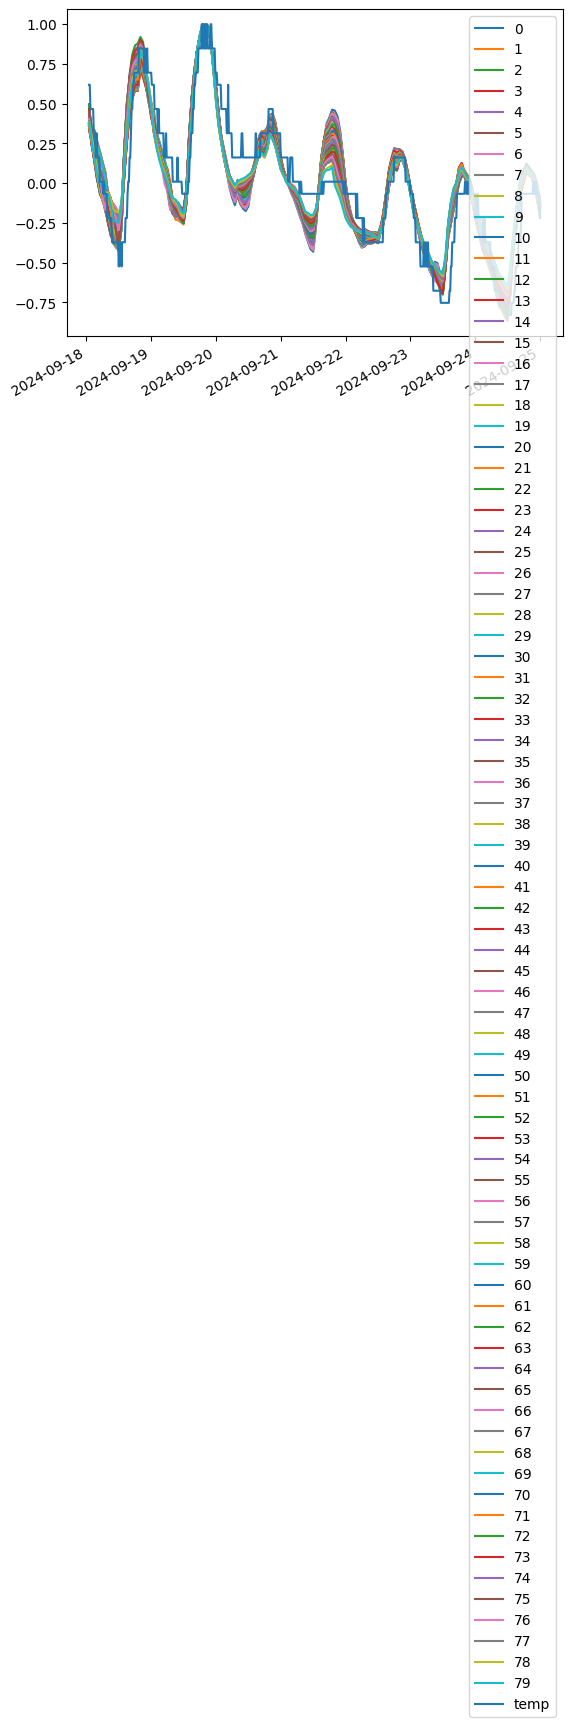

In [387]:
temps_df_norm.plot()

TypeError: _ImageBase.set_data() got an unexpected keyword argument 'blit'

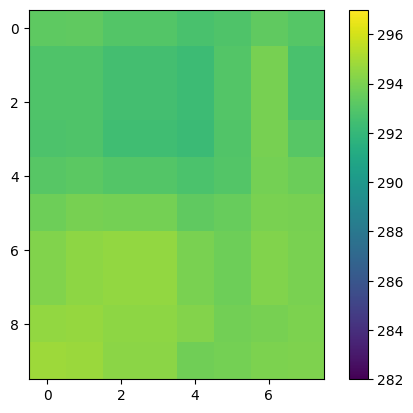

In [469]:
#let's find out where these squares are.

from matplotlib import animation as ani

num_frames = 169
data_shape = (10,8)

temp_series

fig, ax = plt.subplots()

cax = ax.imshow(temp_series[:,:,0], cmap = 'viridis', vmin=282, vmax=297)#vmin=temp_series.min(), vmax = temp_series.max())
fig.colorbar(cax, ax=ax)

def update(frame):
    cax.set_data(blit=True,)
    ax.set_title(f"Frame {frame + 1}")
    return [cax]
animation = ani.FuncAnimation(fig, update, blit=True, frames=num_frames, repeat=True, interval = 200)

plt.show()

In [ ]:
for frame in range(169):
    plt.figure()
    plt.imshow(temp_series[:,:,frame], cmap ='viridis', vmin=282, vmax = 297)
    plt.savefig(f"frame_{frame}.png")
plt.close()

In [276]:
temp_series.shape

(10, 8, 168)

In [282]:
temp_series[:,:,0].shape

(10, 8)

In [284]:
temp_series[:,:,0]

array([[293.25278, 293.34067, 292.99496, 292.99496, 292.70004, 292.87582,
        293.327  , 293.05942],
       [292.87387, 292.84848, 292.50473, 292.50473, 292.26645, 292.993  ,
        293.94223, 292.68832],
       [292.87387, 292.84848, 292.50473, 292.50473, 292.26645, 292.993  ,
        293.94223, 292.68832],
       [292.7899 , 292.84457, 292.37387, 292.37387, 292.24496, 292.90903,
        293.93637, 293.12973],
       [293.12778, 293.243  , 292.97934, 292.97934, 292.7684 , 293.0145 ,
        293.84653, 293.61996],
       [293.71567, 293.90317, 293.88168, 293.88168, 293.3563 , 293.49496,
        293.97348, 293.94614],
       [294.16098, 294.44028, 294.5555 , 294.5555 , 293.98325, 293.66098,
        294.17856, 293.993  ],
       [294.16098, 294.44028, 294.5555 , 294.5555 , 293.98325, 293.66098,
        294.17856, 293.993  ],
       [294.55746, 294.62973, 294.47934, 294.47934, 294.2274 , 293.81137,
        293.90903, 294.0184 ],
       [294.827  , 294.72348, 294.37778, 294.37778, 293

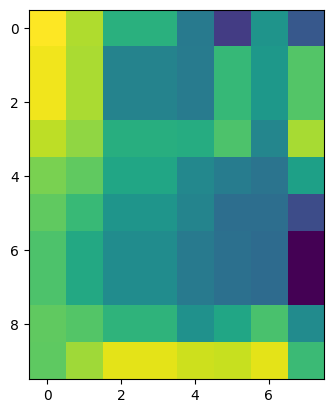

In [319]:
plt.imshow(np.diff(temp_series[:,:])[:,:,7])

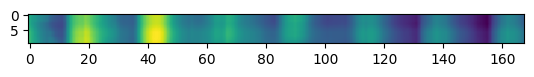

In [333]:
#get averages over different axes
plt.imshow(temp_series.mean(axis = 1))

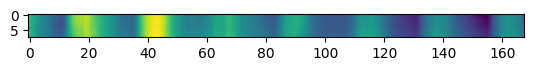

In [334]:
plt.imshow(temp_series.mean(axis = 0))

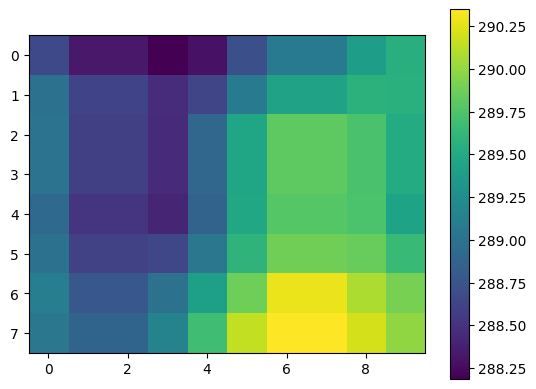

In [340]:
plt.imshow(temp_series.mean(axis = 2).T)
plt.colorbar()

# aside --- new york east coast to verify orientation of source

In [341]:
#get temperature GeoTIFF of the east coast

#reversed map coordinates
era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate('2024-09-18', '2024-09-30')

ny_lon_lat = [-74.1444869, 40.6976312] #moo york city
ny_center_point = ee.Geometry.Point(ny_lon_lat)
east_coast_region_of_interest = center_point.buffer(3_000_000) #meters

def accumulate_bands(image, previous):
    image = image.select('temperature_2m').toFloat()
    return ee.Image(previous).addBands(image)

initial_image = ee.Image().toFloat()

composite_image = ee.Image(era5.iterate(accumulate_bands, initial_image))

# Export the composite image to Google Drive
task = ee.batch.Export.image.toDrive(
    image=composite_image,
    description='ERA5_Temperature_TimeSeries_NWMass_native_31km_reversedmapcoordinates',
    region=east_coast_region_of_interest,
    scale=10000,  # Use native resolution for ERA5
    fileFormat='GeoTIFF'
)
task.start()

print('done')

done


In [342]:



tiff_file = '../weather-data/era5/ERA5_Temperature_TimeSeries_NY_eastcoast.tif'

with rasterio.open(tiff_file) as src:
    src_data = src.read()
    # temperature_data = src.read(1)

print(src_data.shape)


#normal coordinates
# tiff_file = '../weather-data/era5/ERA5_Temperature_TimeSeries_NWMass_native.tif'

# with rasterio.open(tiff_file) as src:
#     src_data = src.read()
#     # temperature_data = src.read(1)


(169, 602, 845)


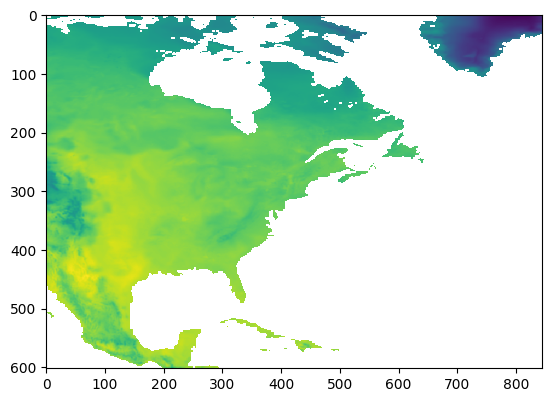

In [345]:
plt.imshow(src_data[2])

In [ ]:
#ok, great. The image imshows like a normal map.

# back to the NW mass results

C:\Users\David\AppData\Local\Temp\ipykernel_8936\550990478.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


IndexError: index 168 is out of bounds for axis 2 with size 168

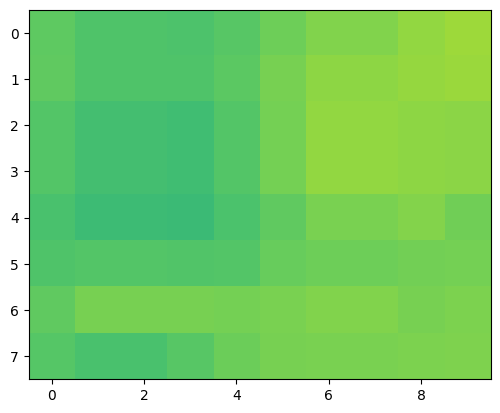

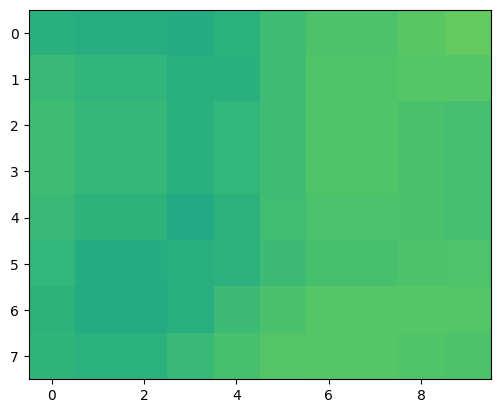

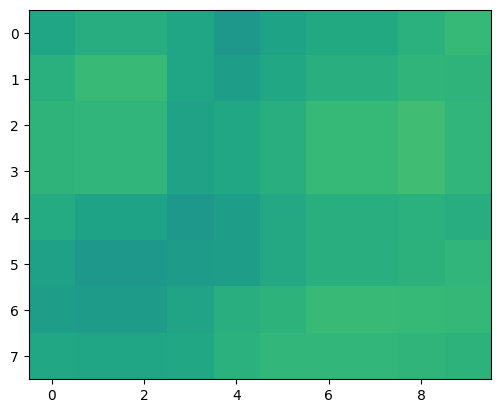

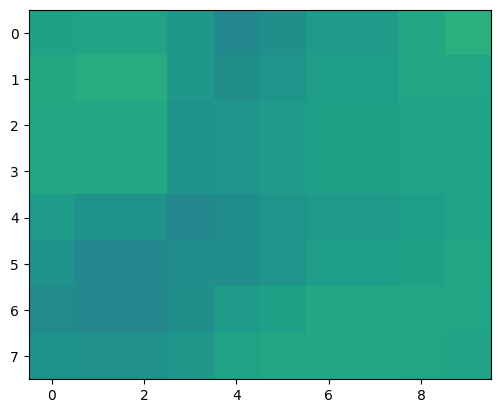

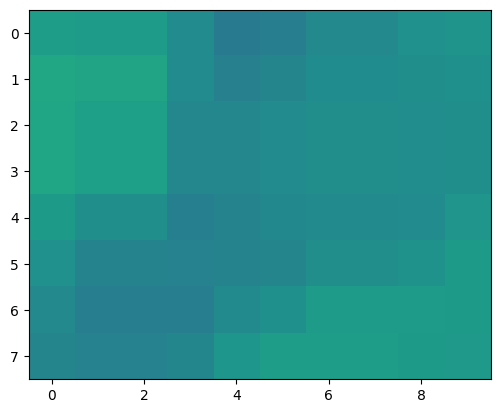

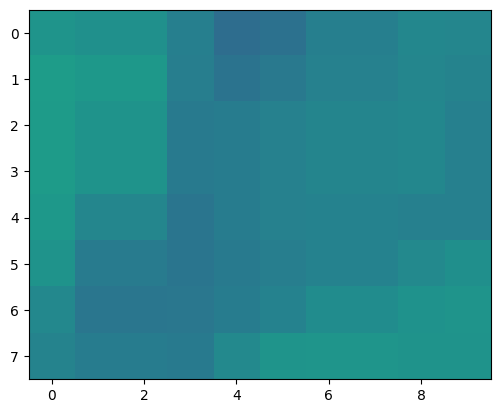

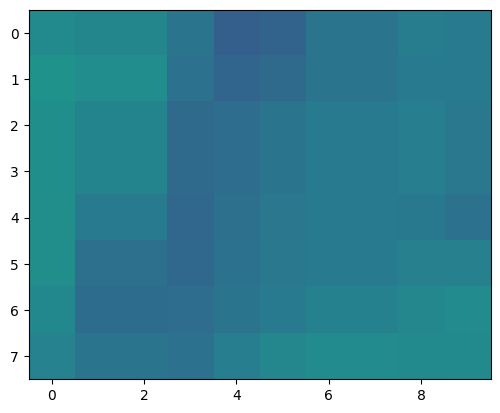

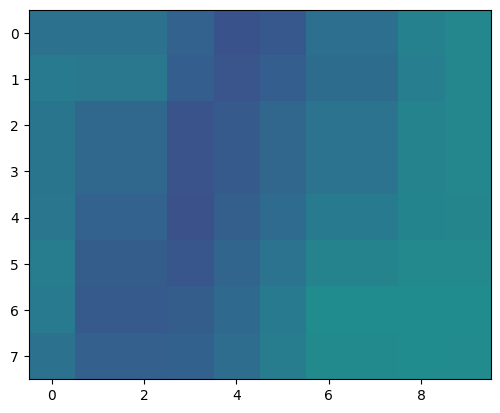

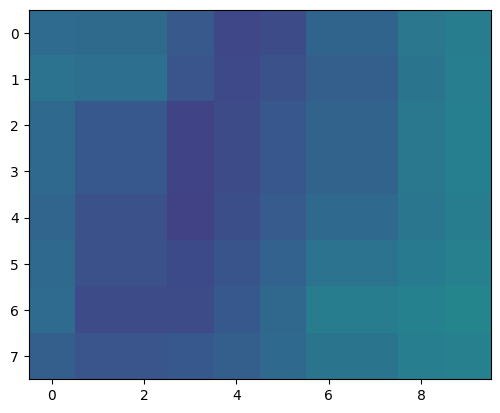

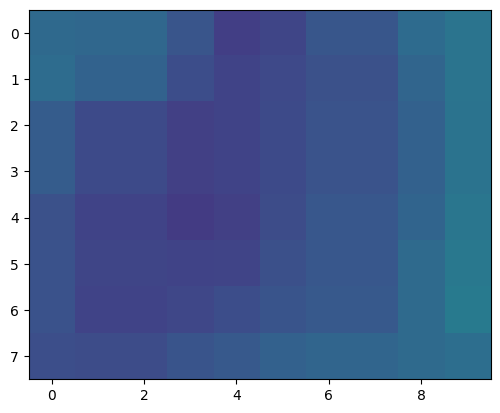

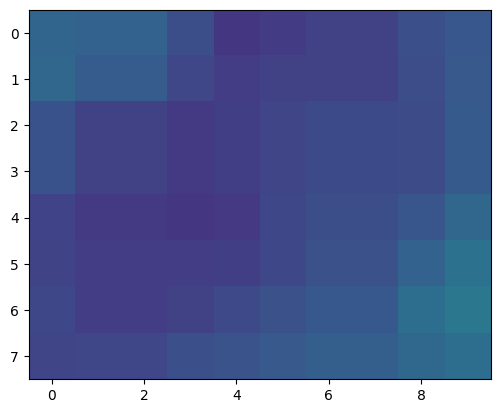

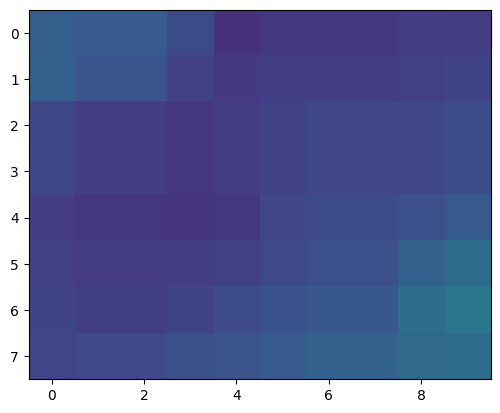

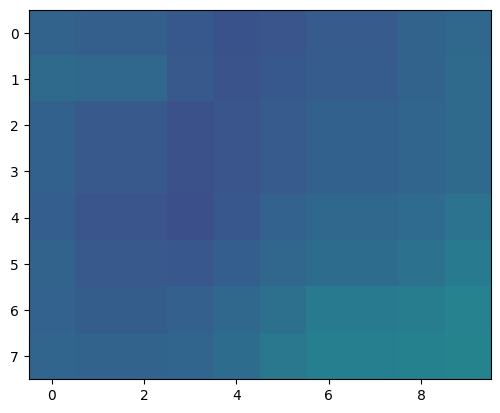

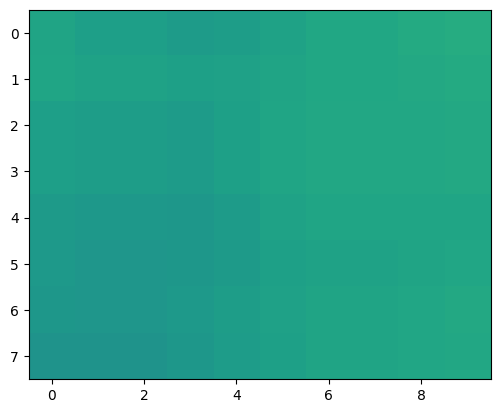

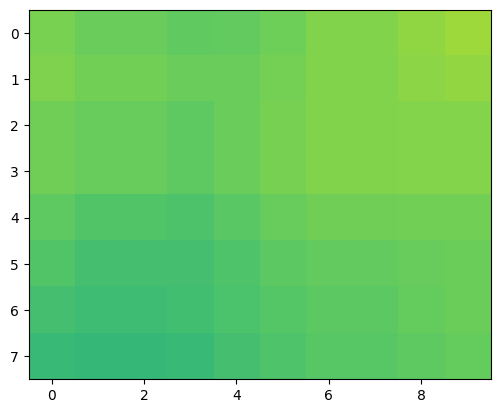

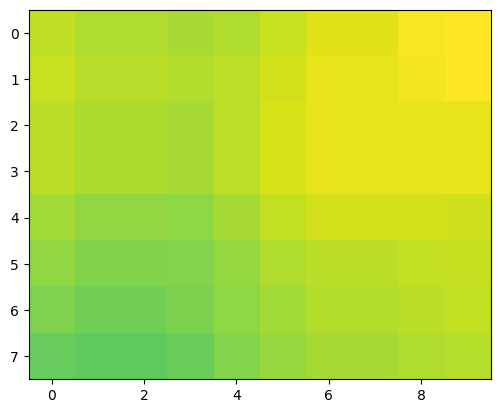

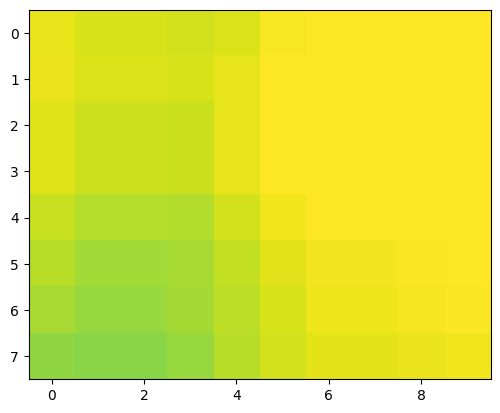

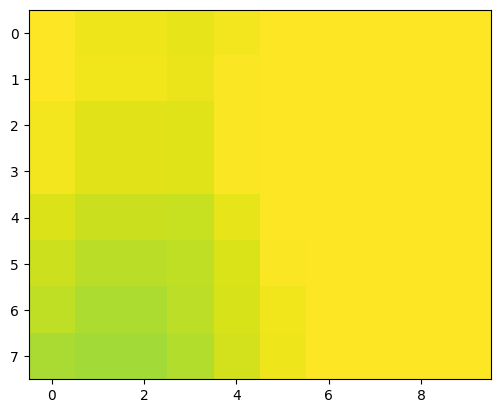

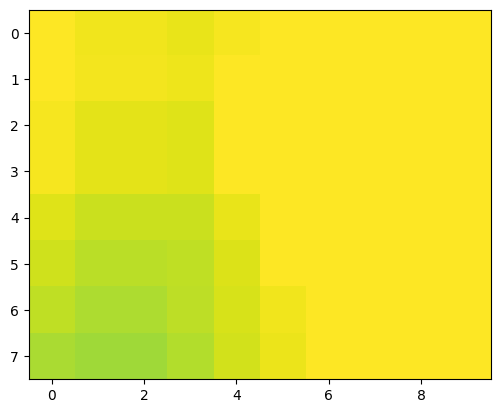

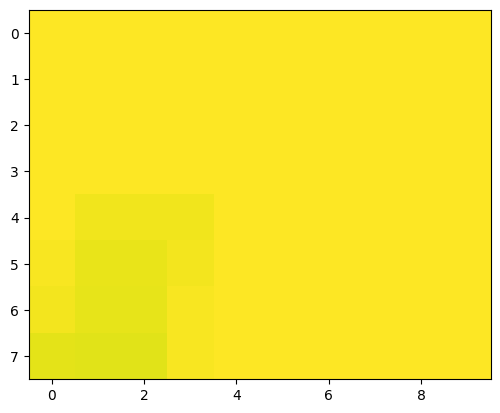

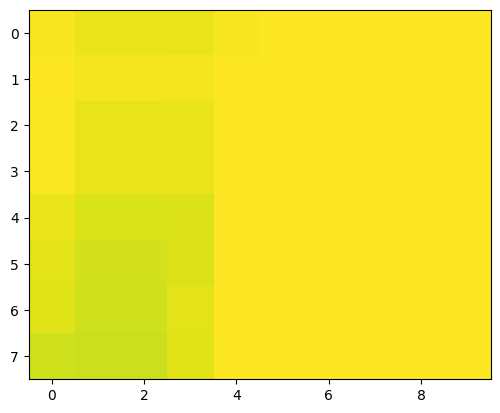

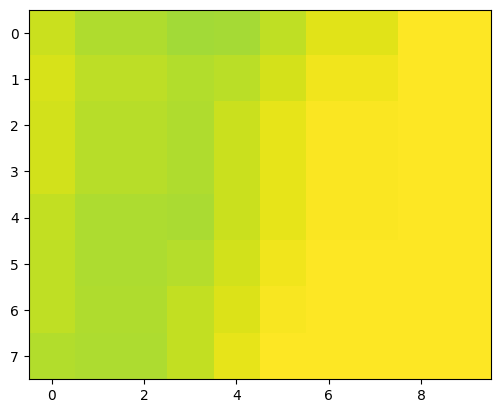

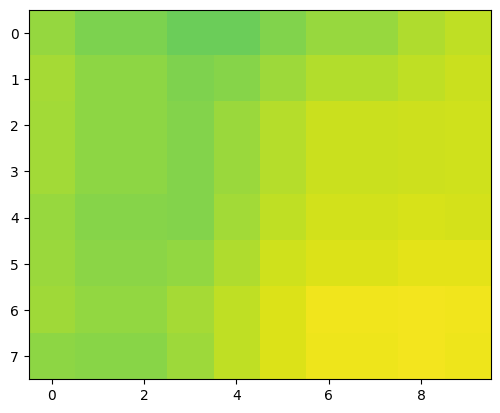

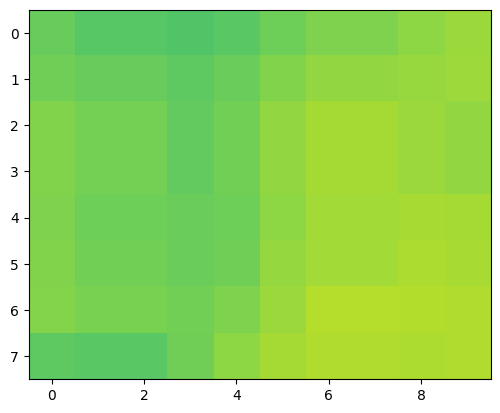

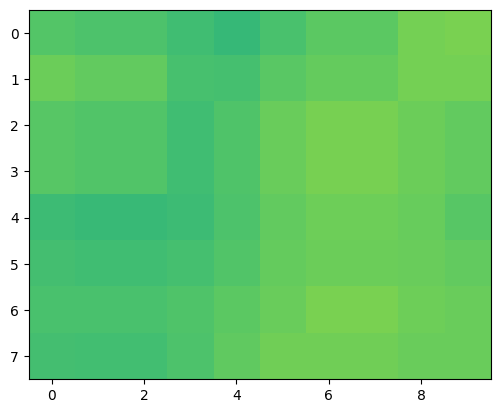

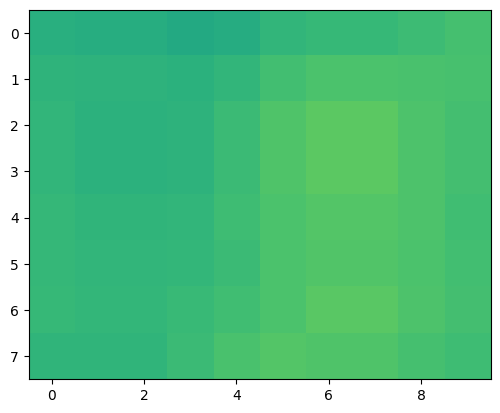

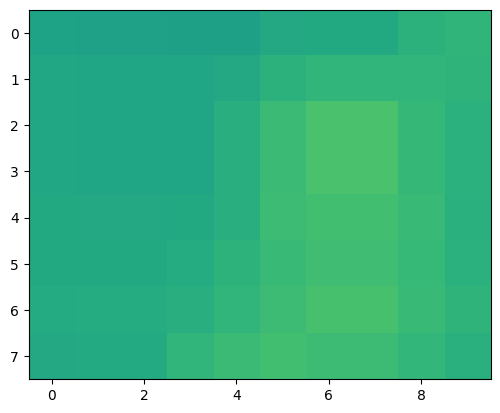

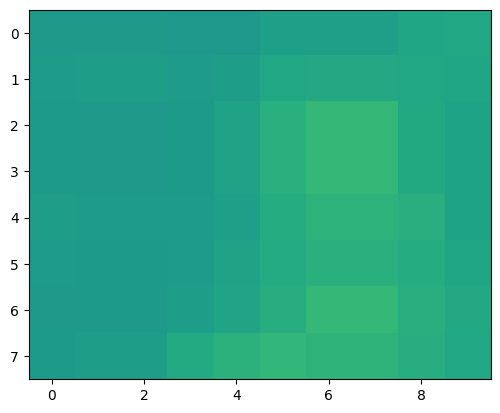

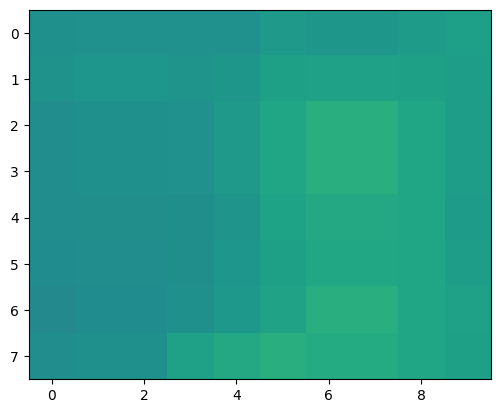

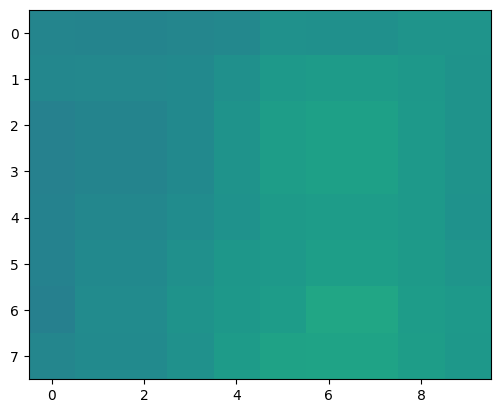

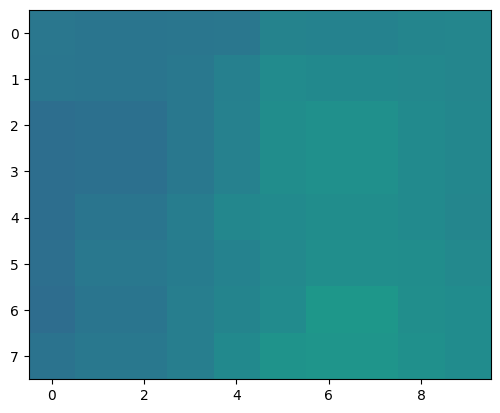

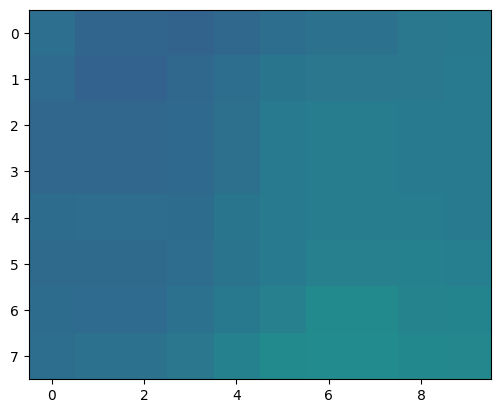

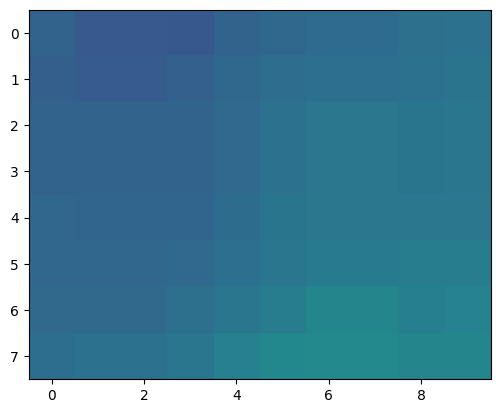

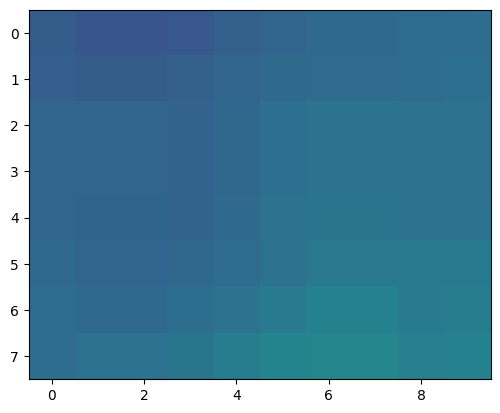

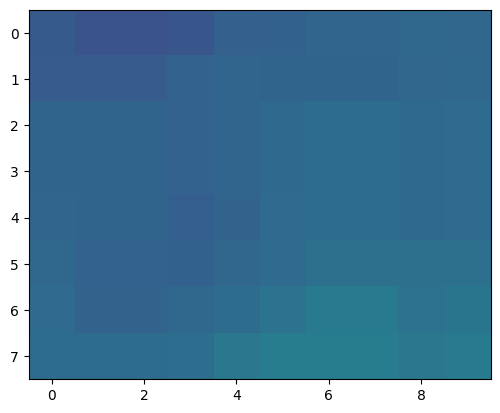

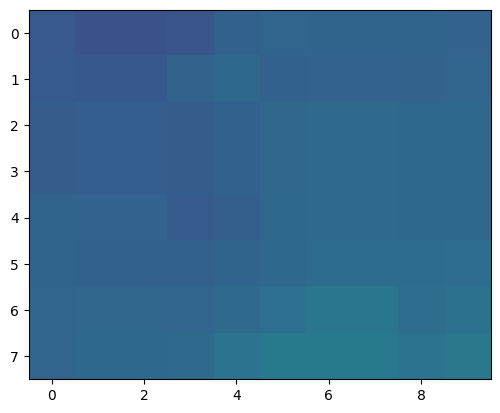

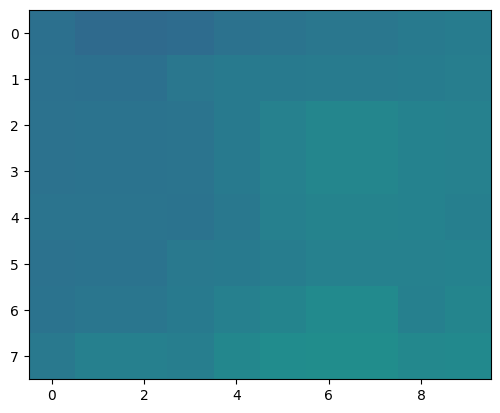

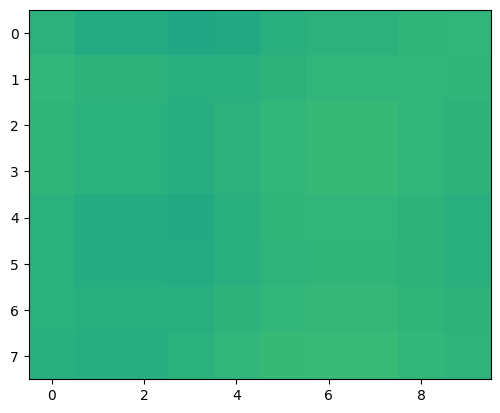

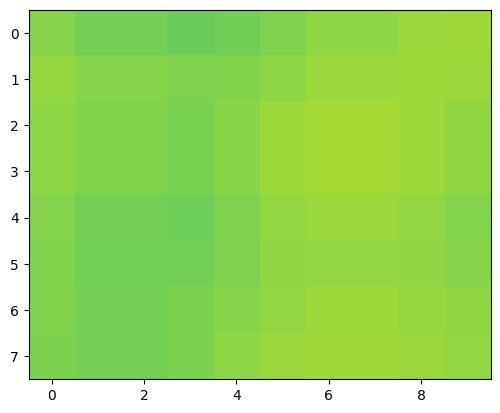

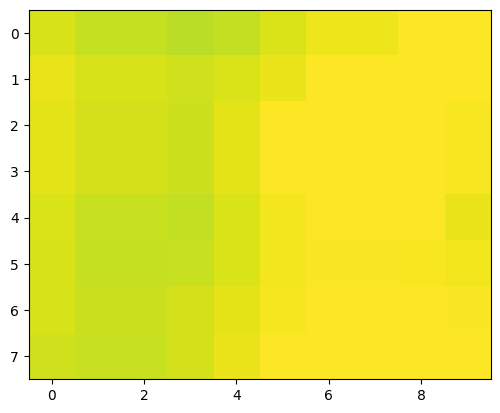

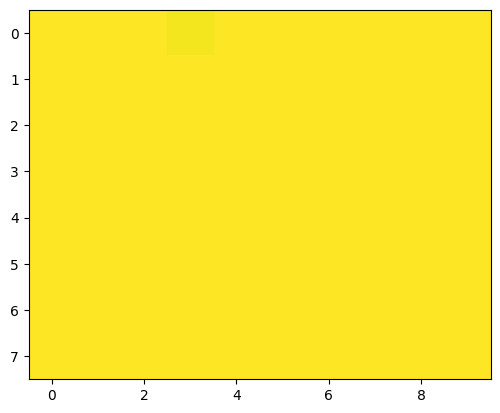

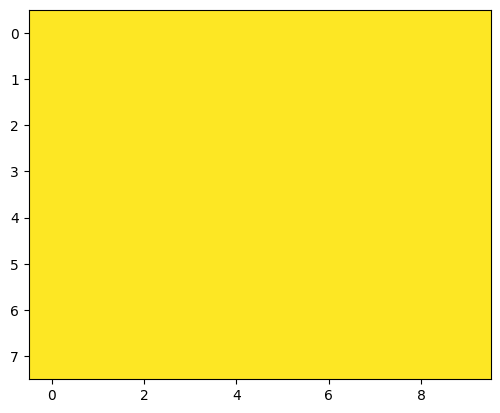

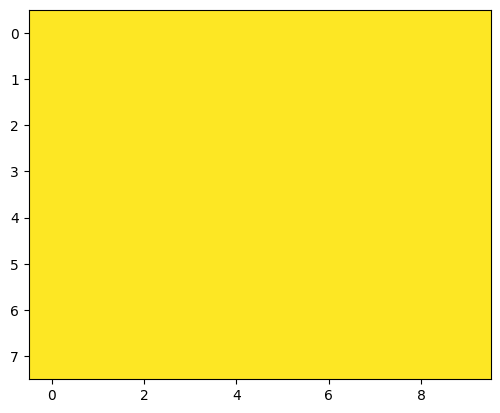

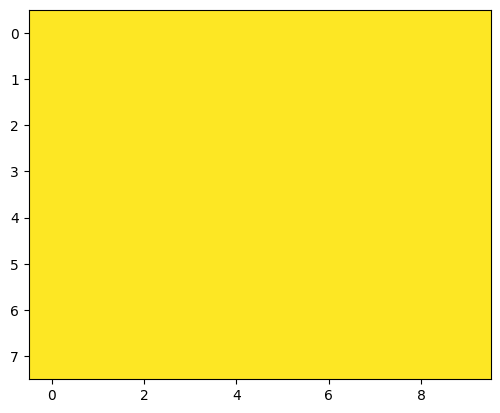

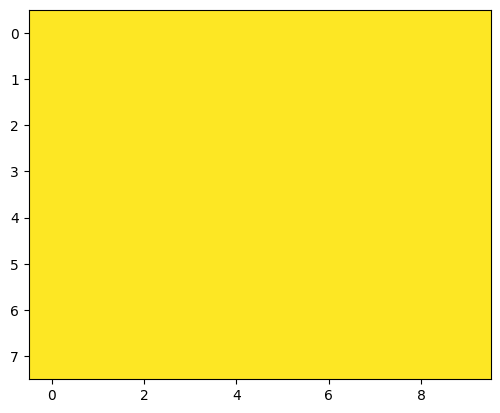

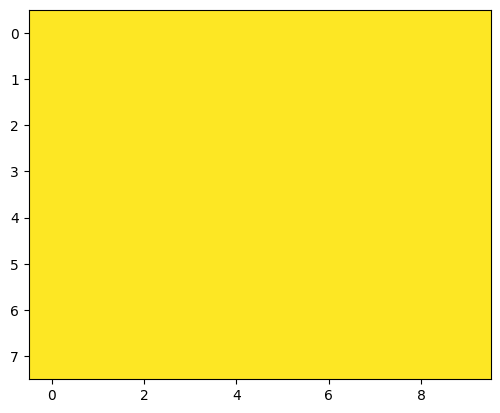

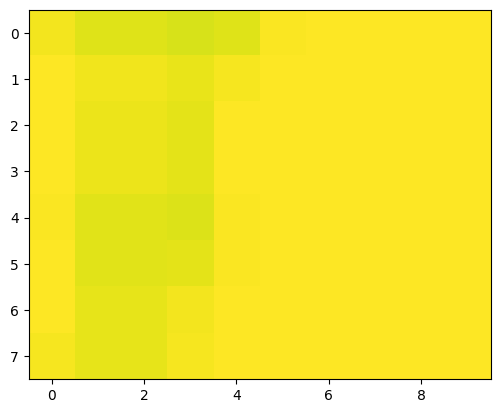

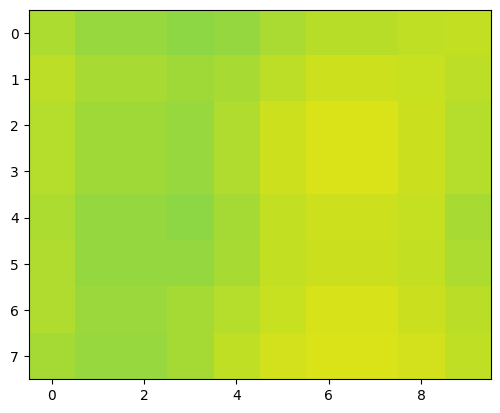

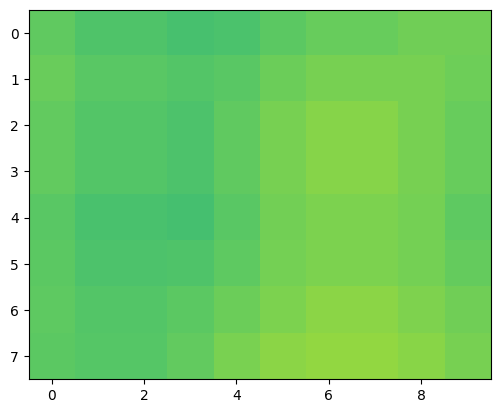

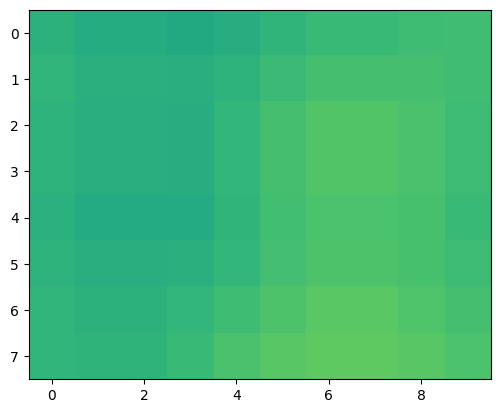

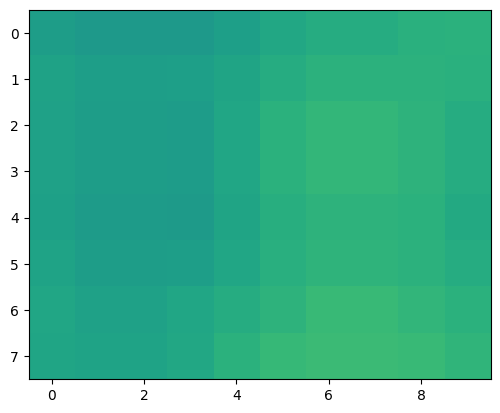

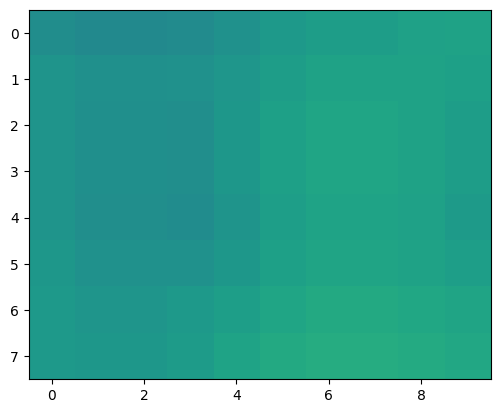

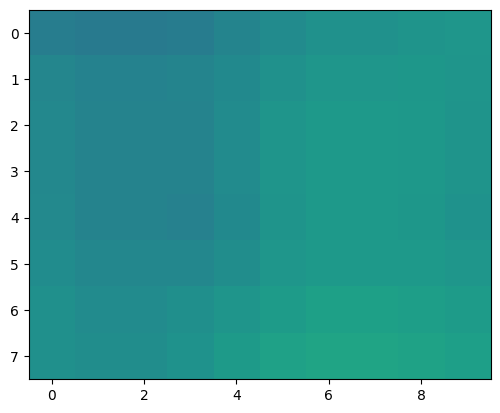

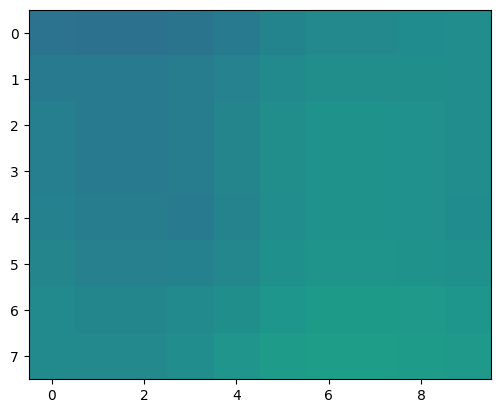

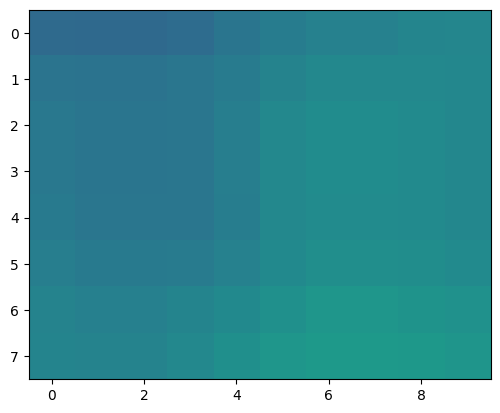

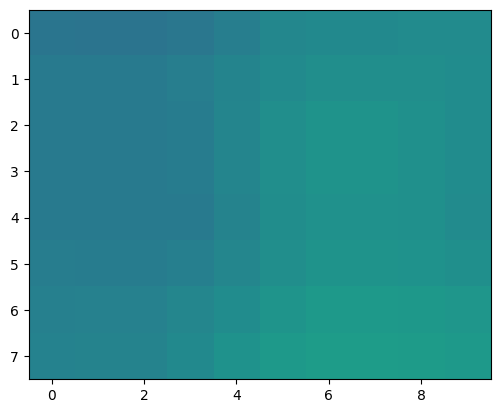

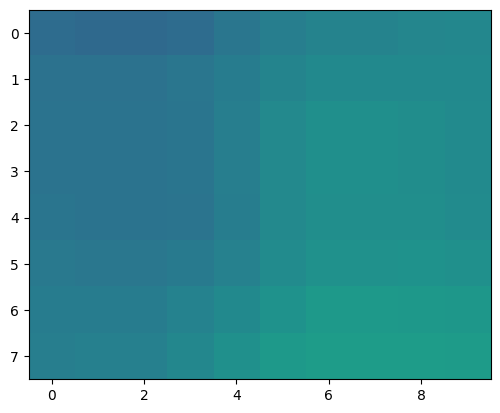

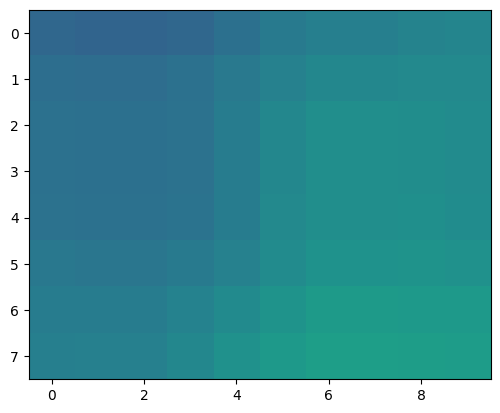

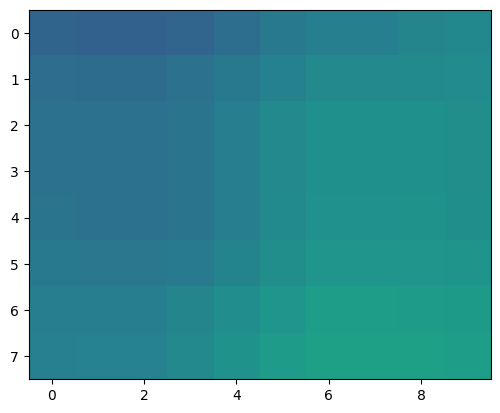

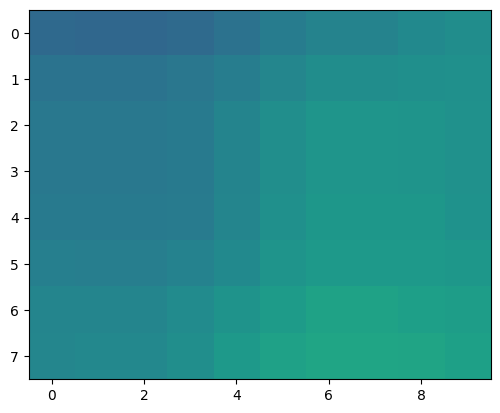

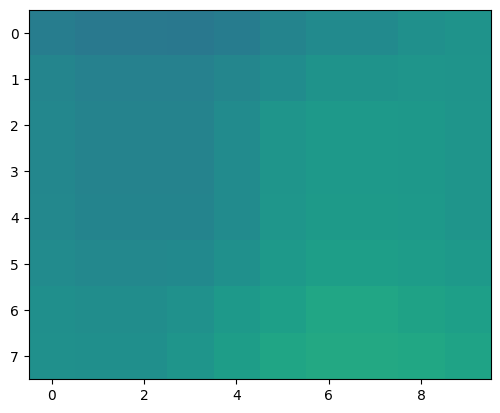

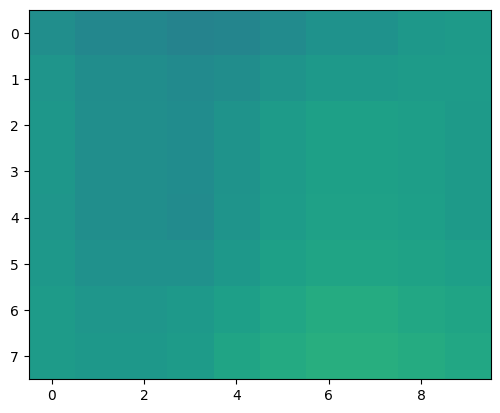

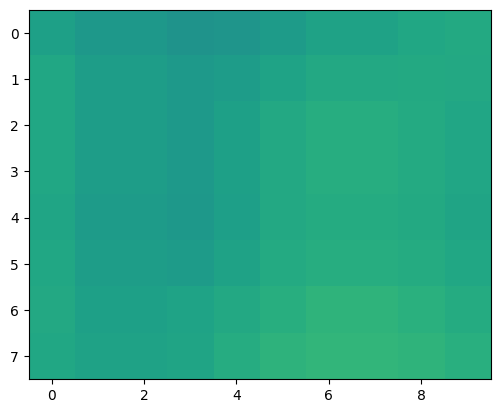

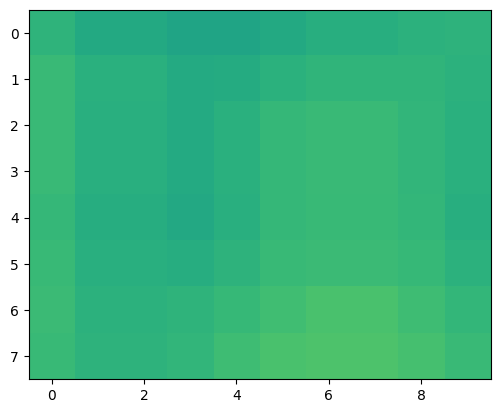

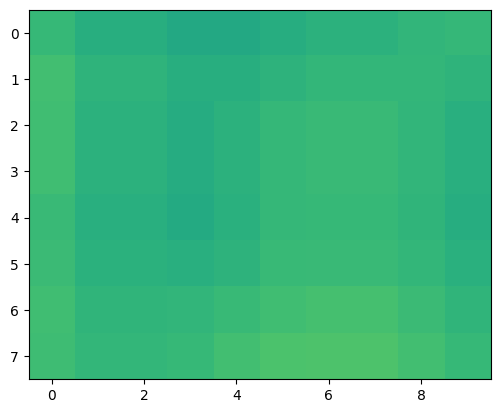

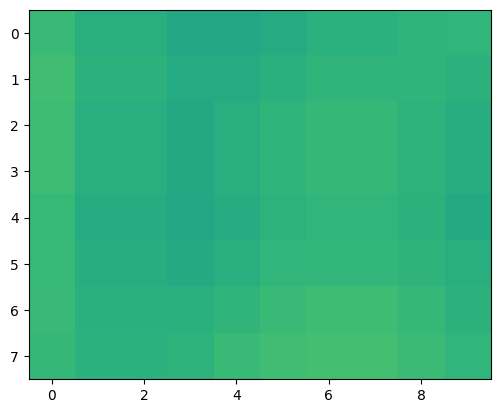

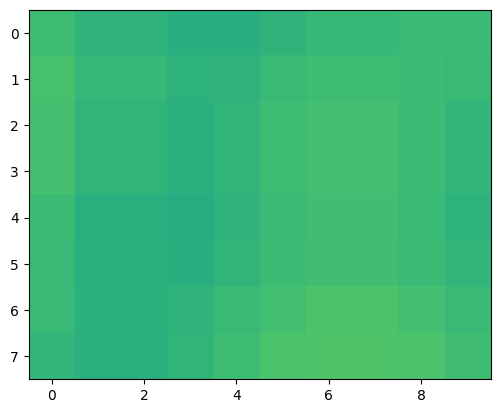

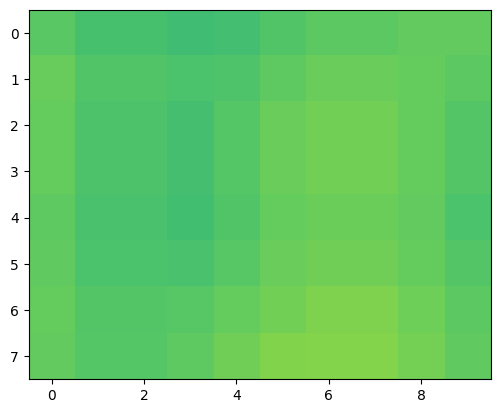

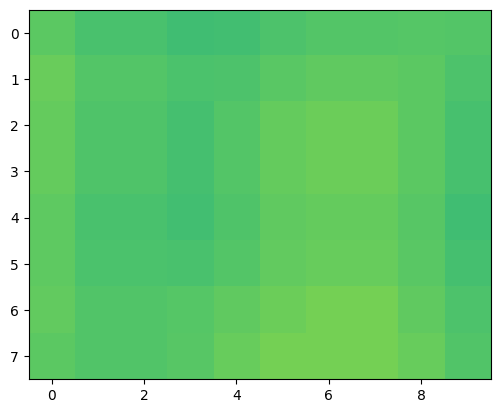

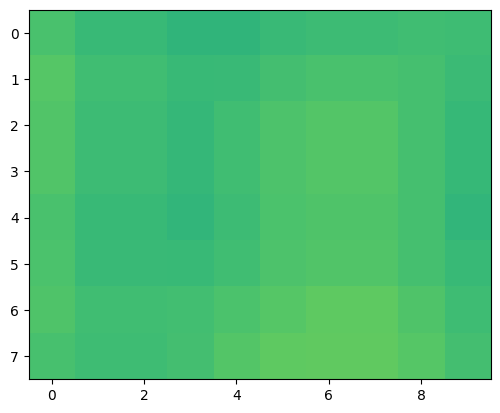

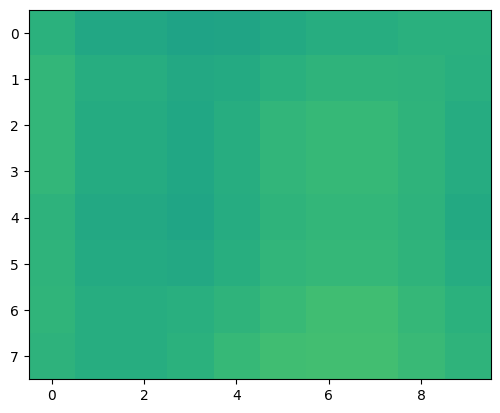

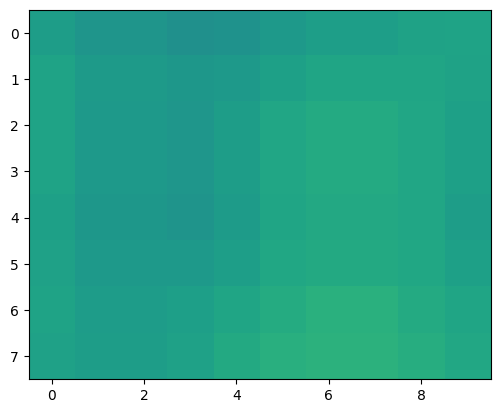

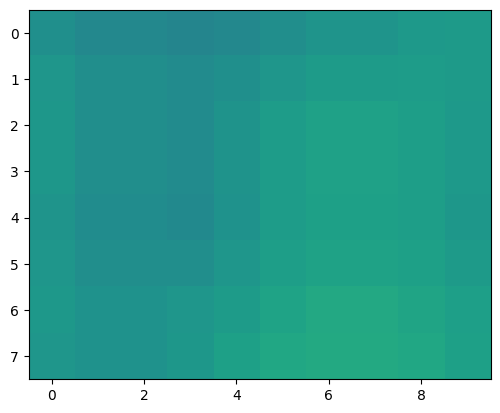

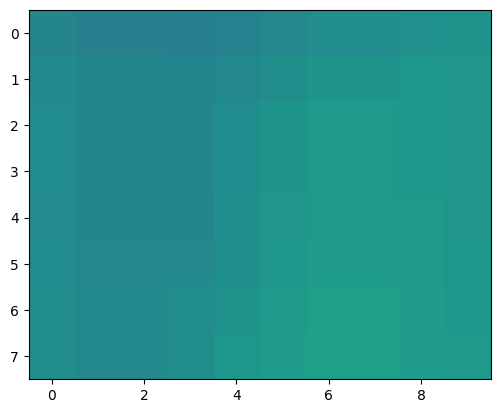

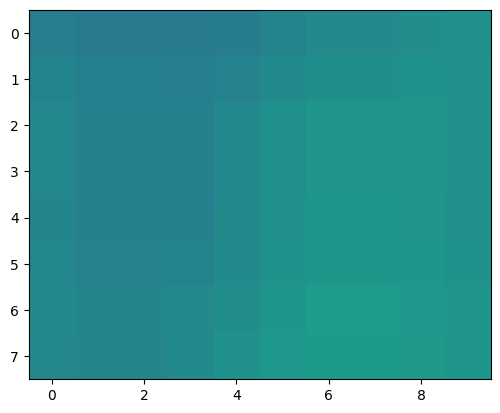

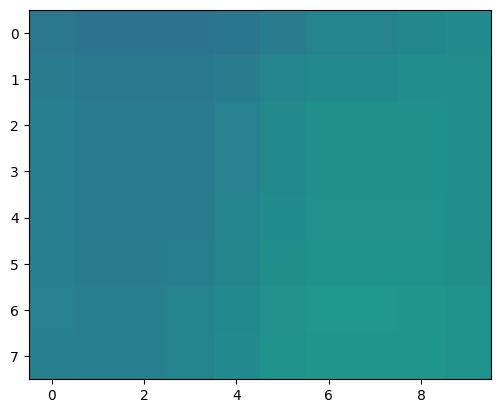

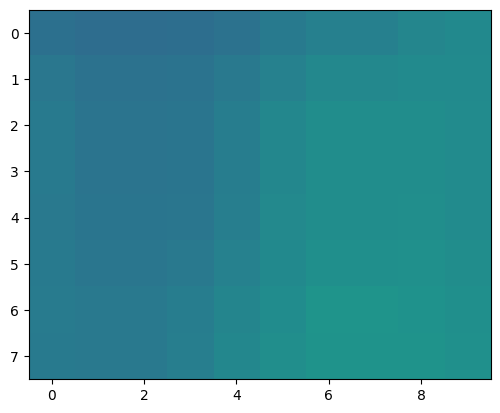

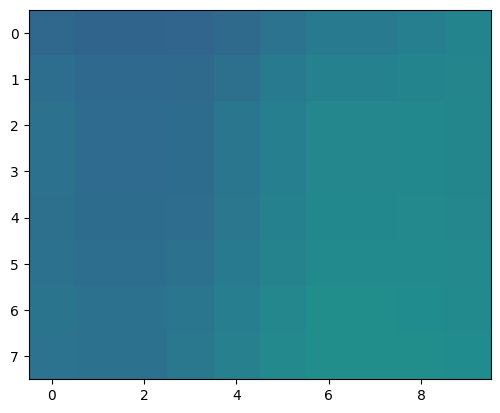

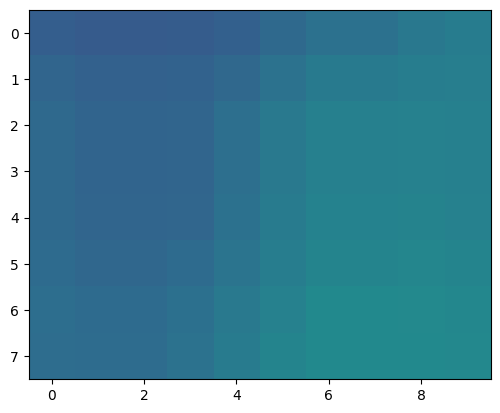

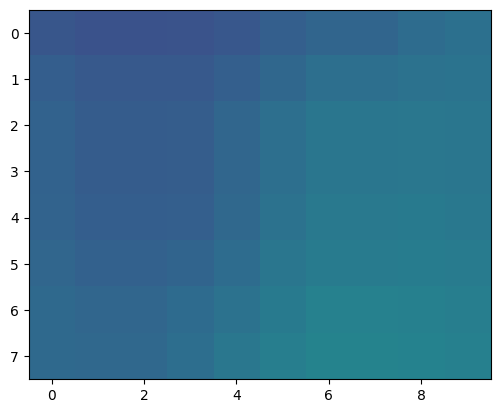

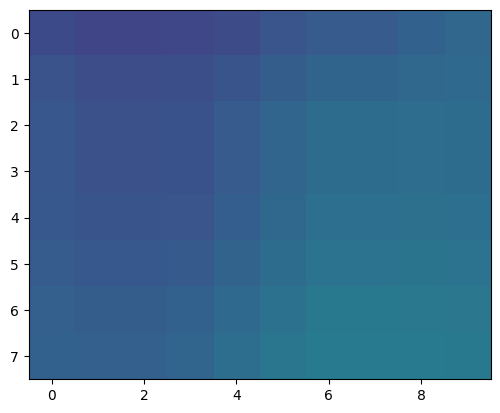

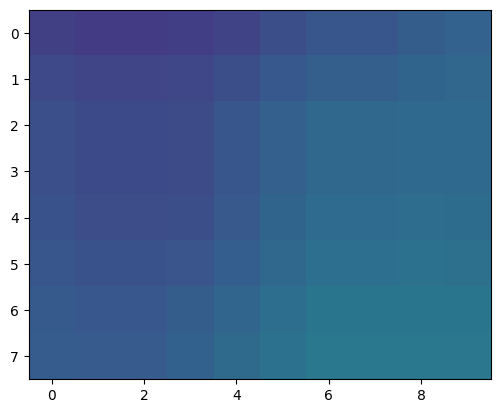

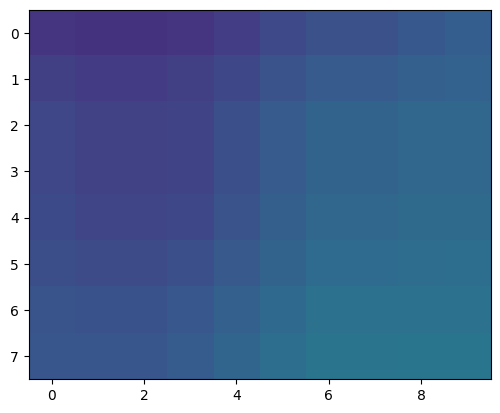

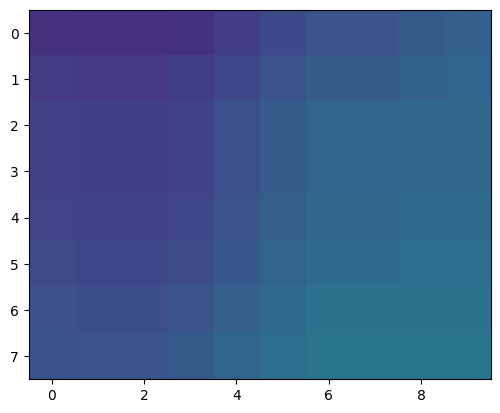

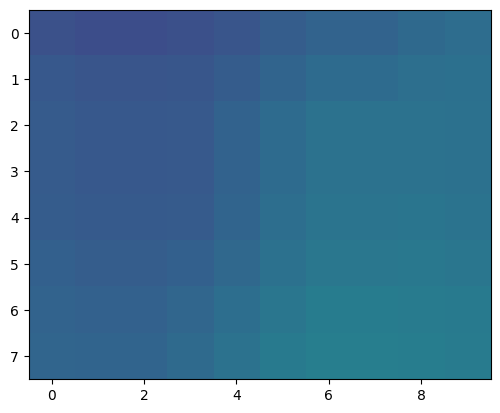

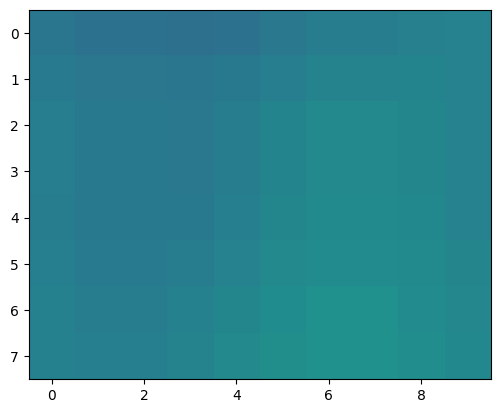

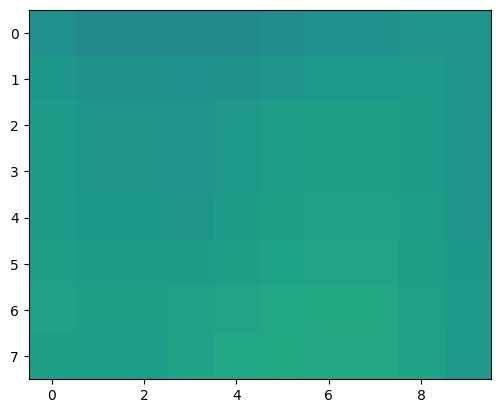

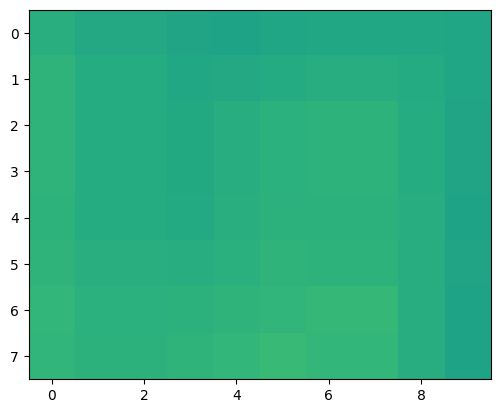

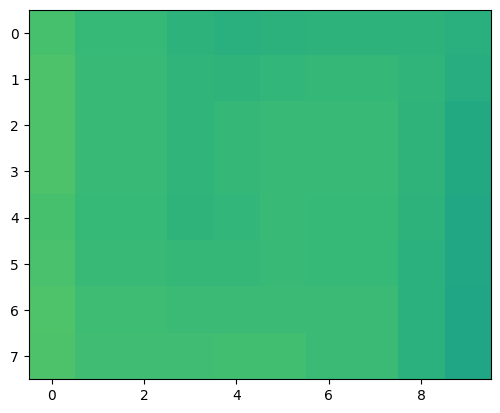

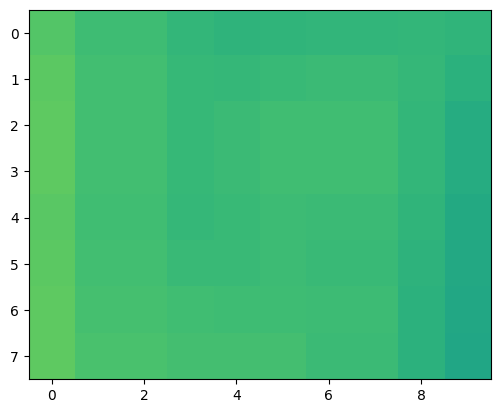

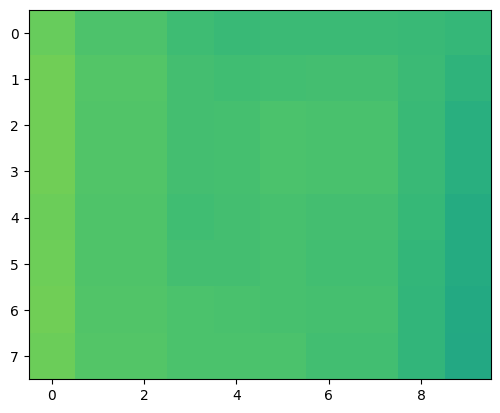

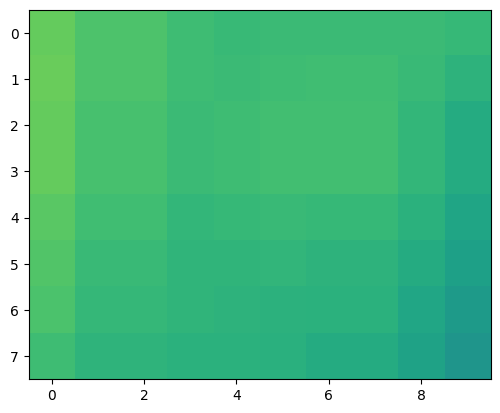

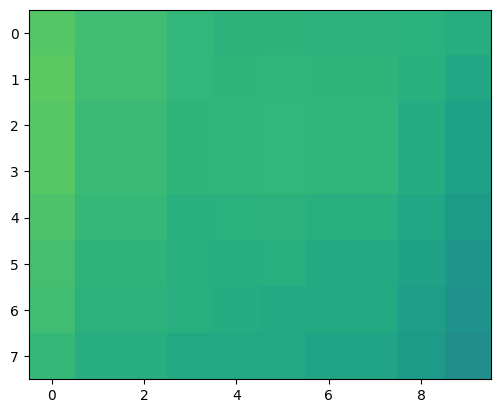

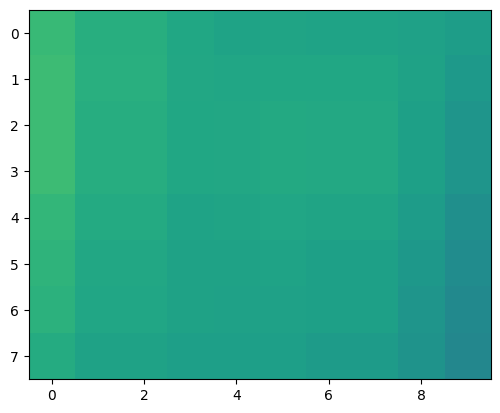

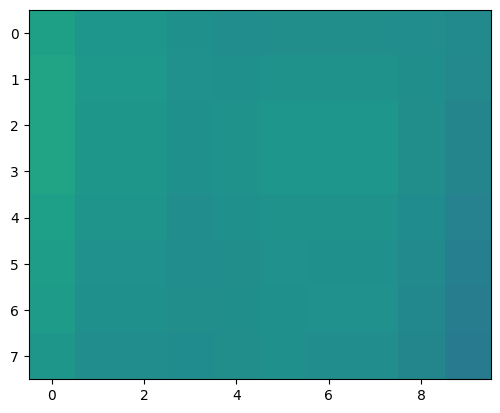

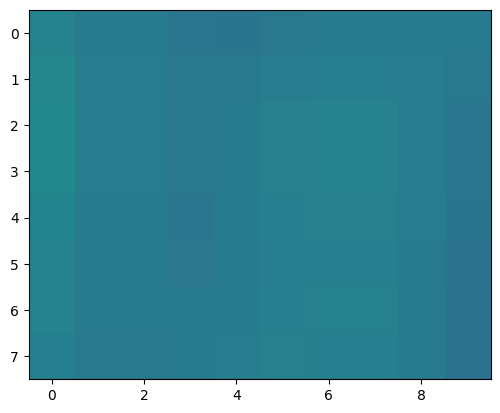

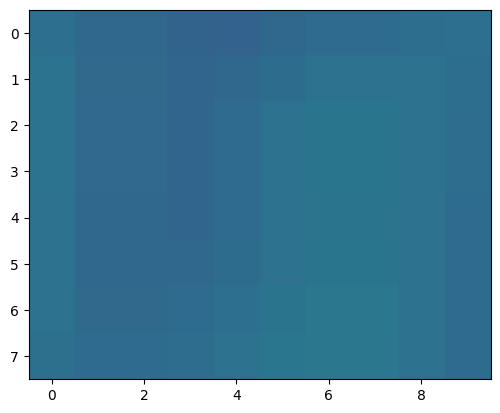

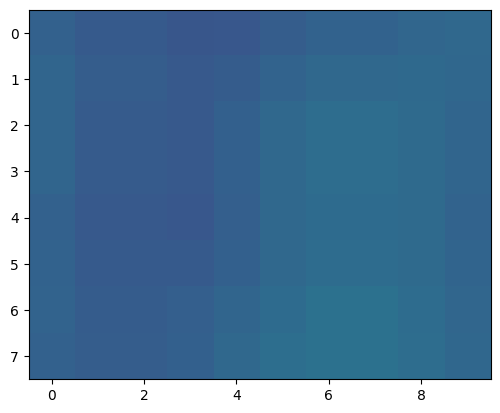

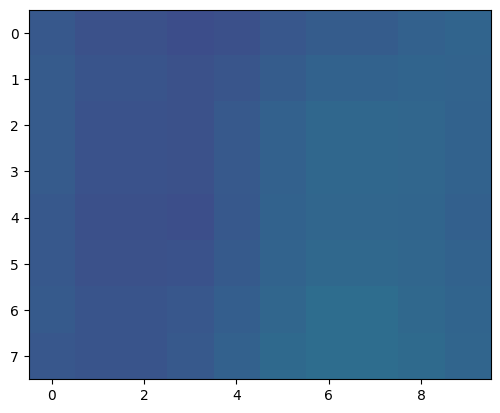

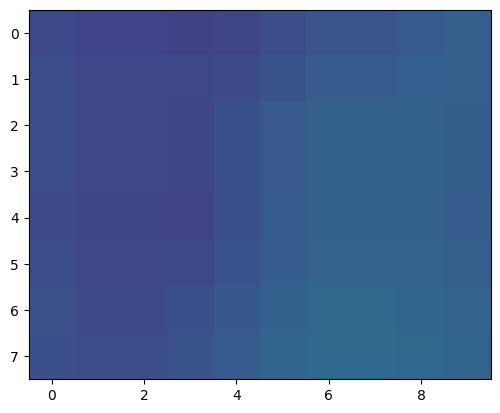

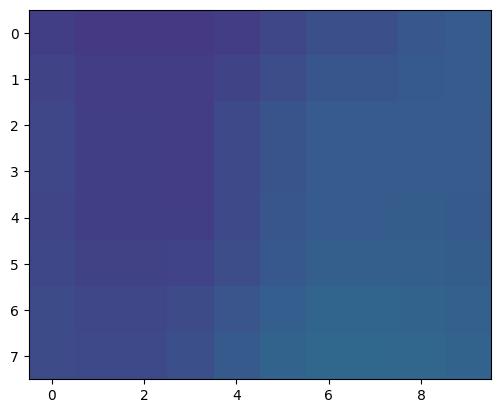

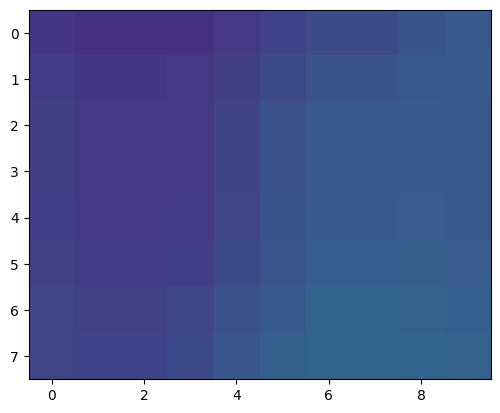

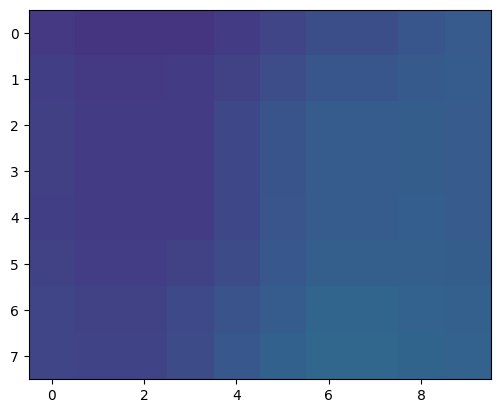

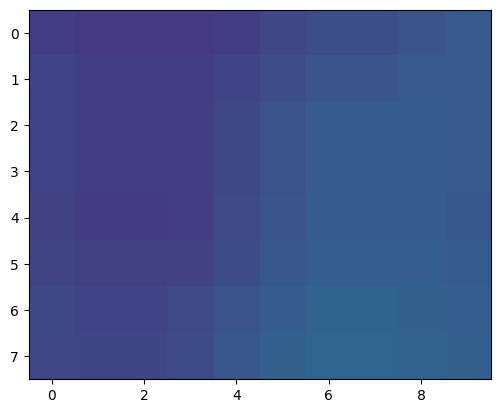

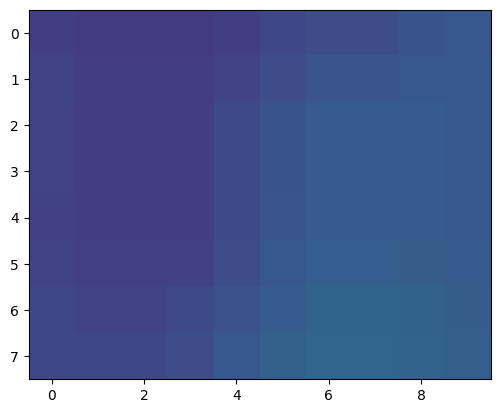

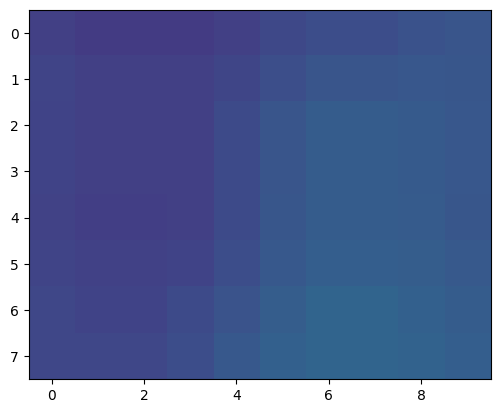

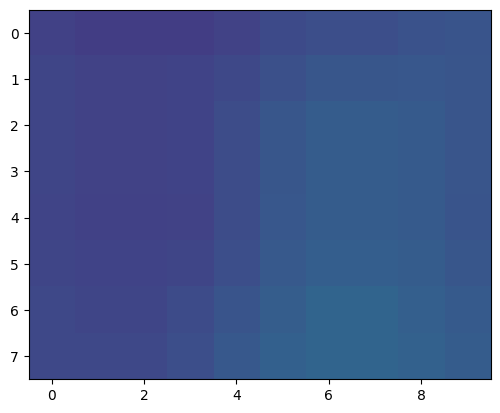

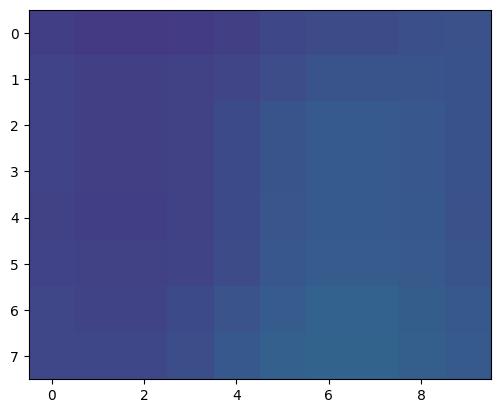

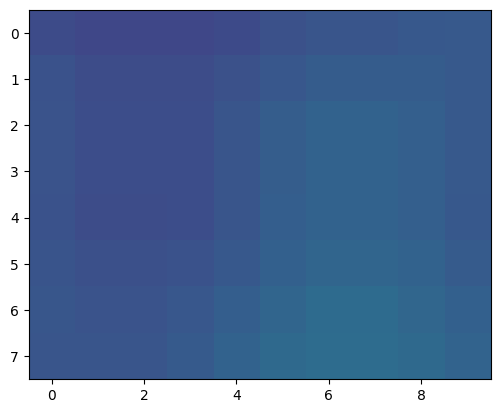

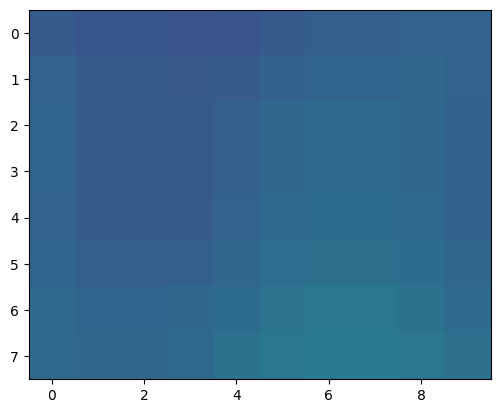

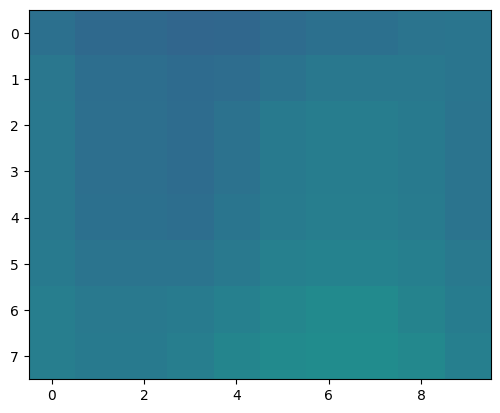

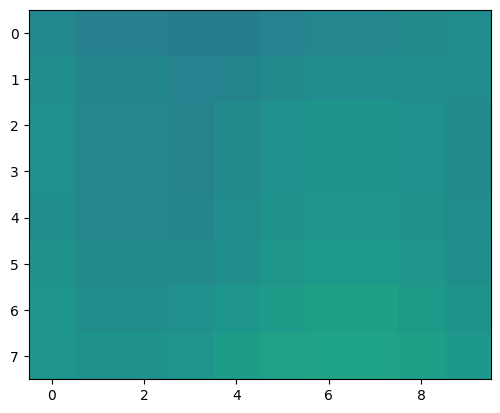

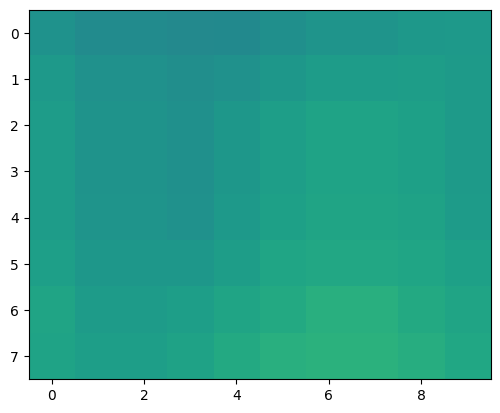

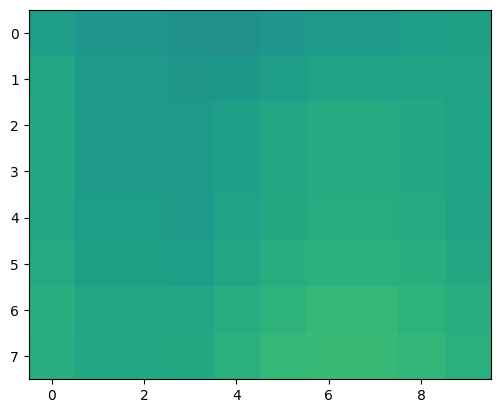

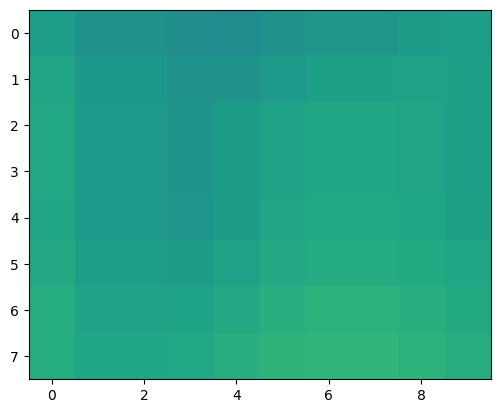

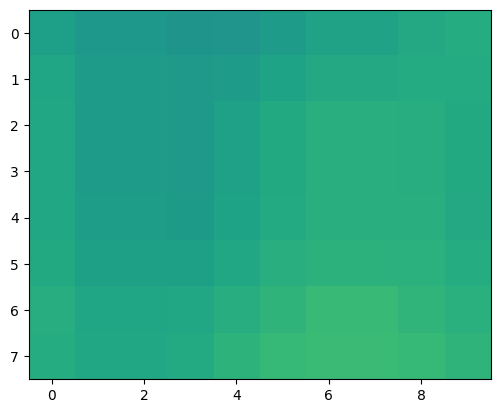

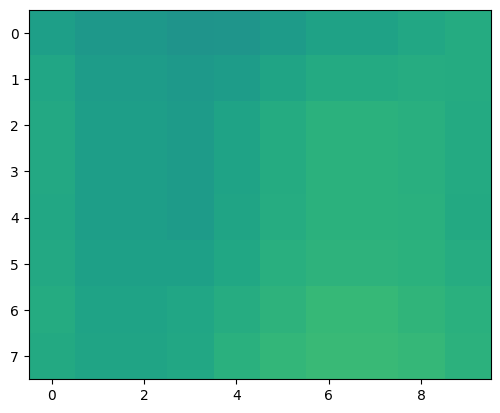

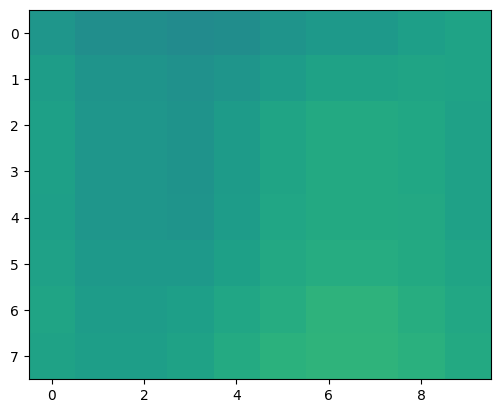

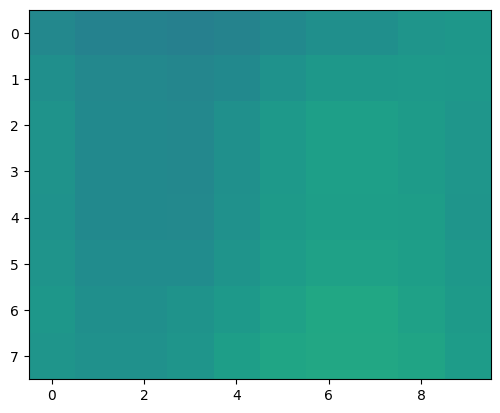

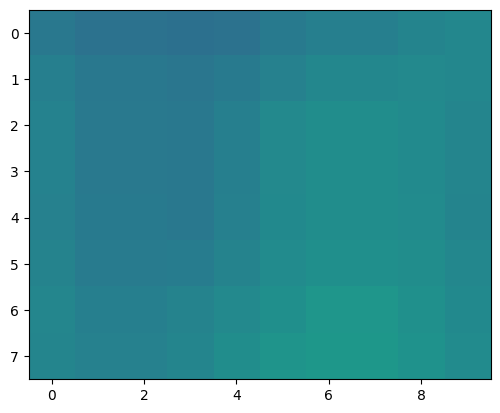

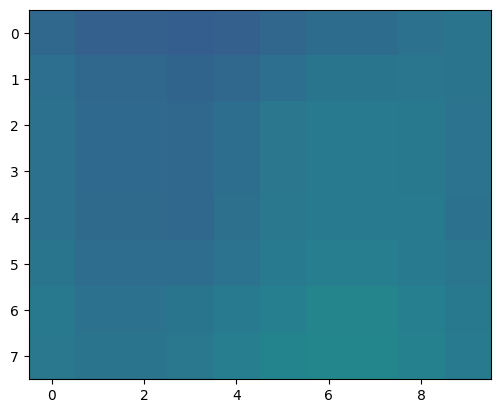

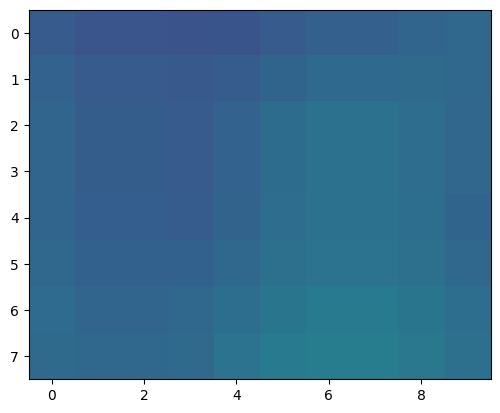

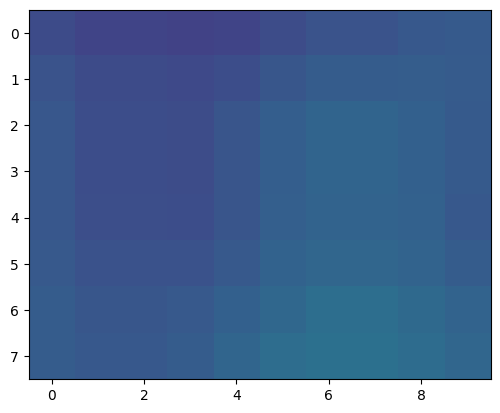

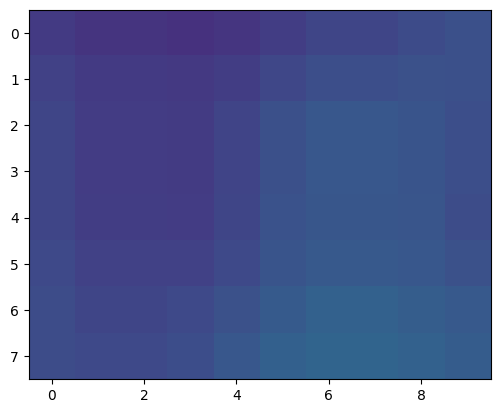

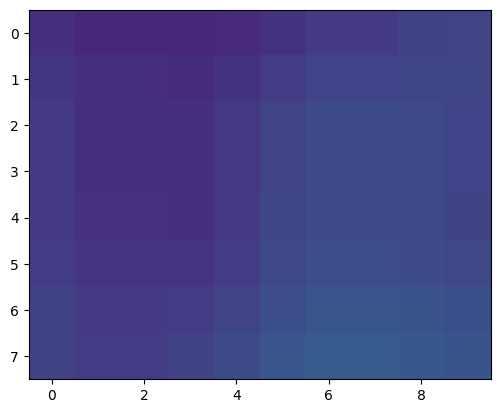

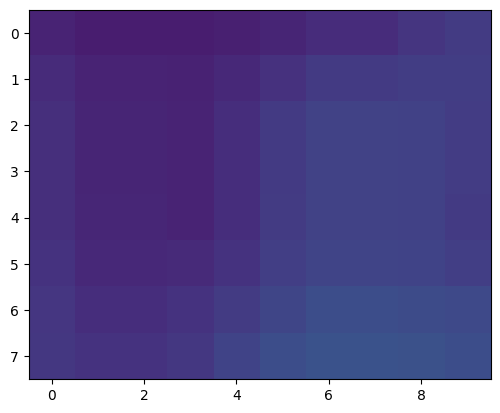

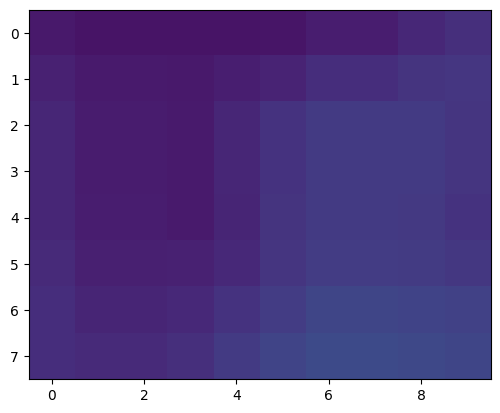

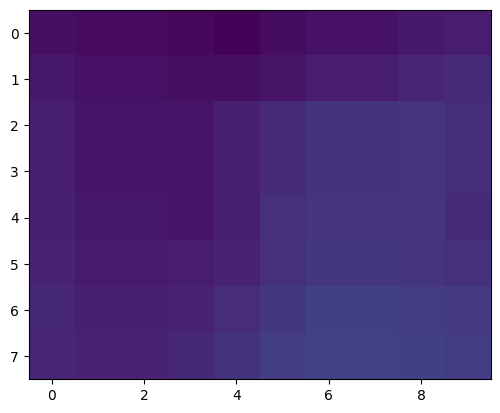

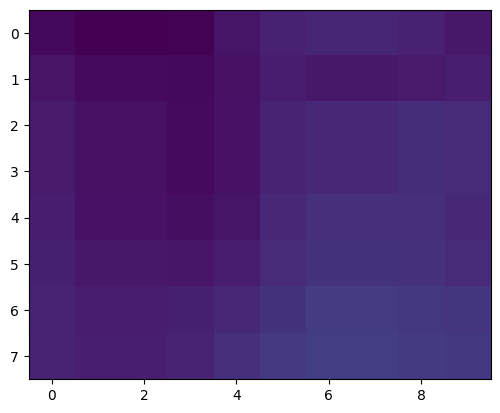

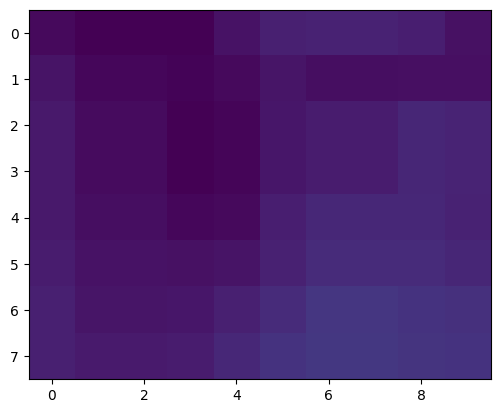

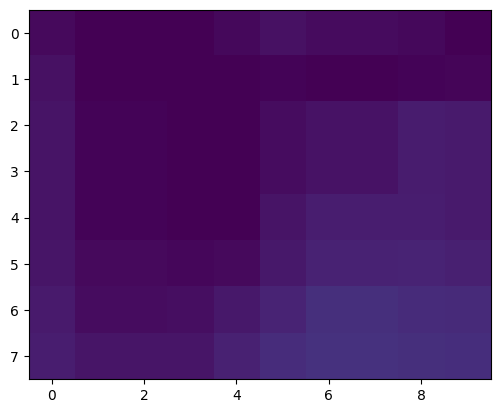

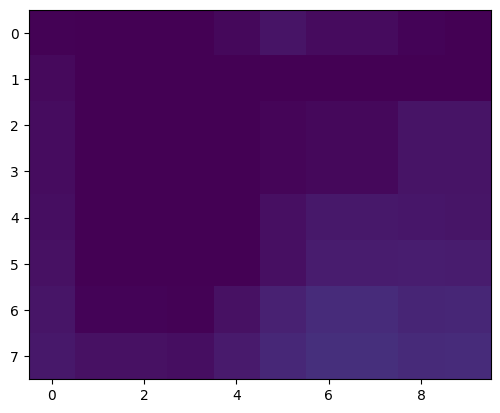

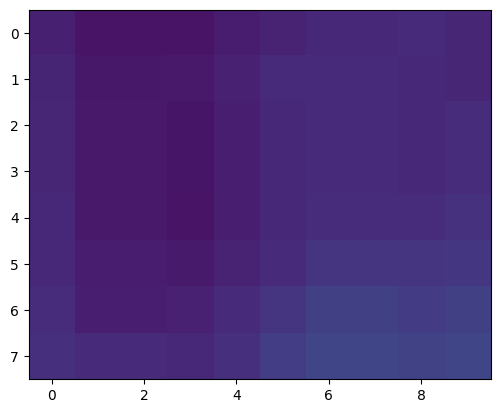

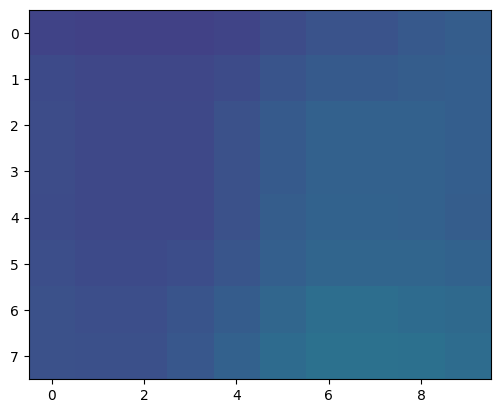

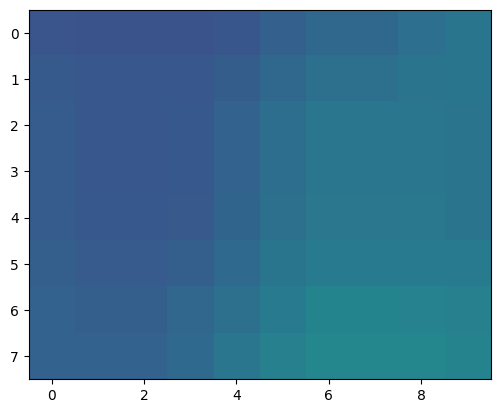

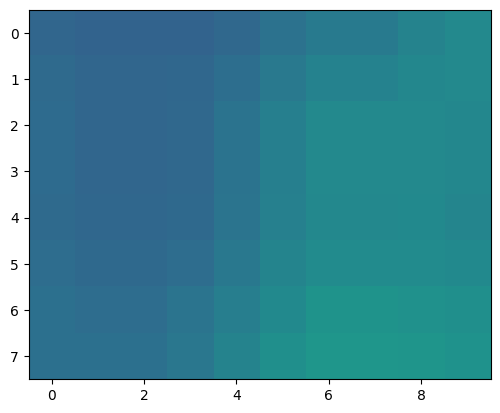

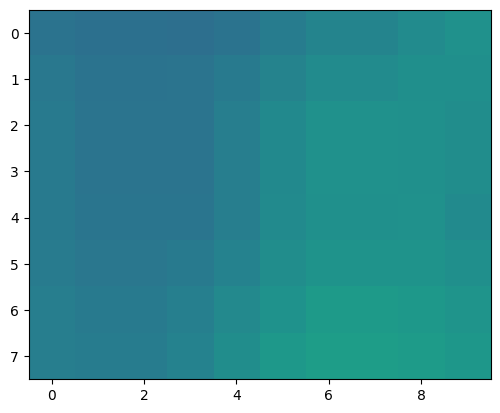

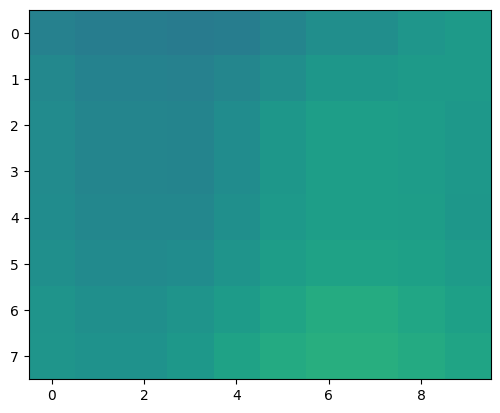

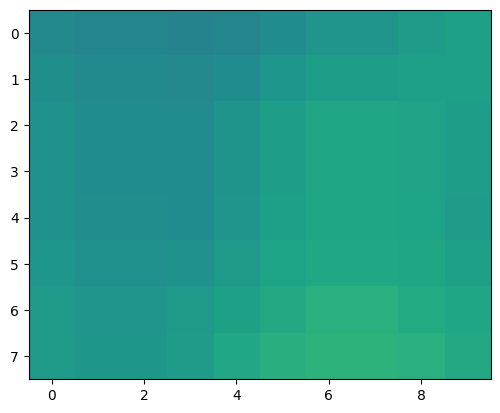

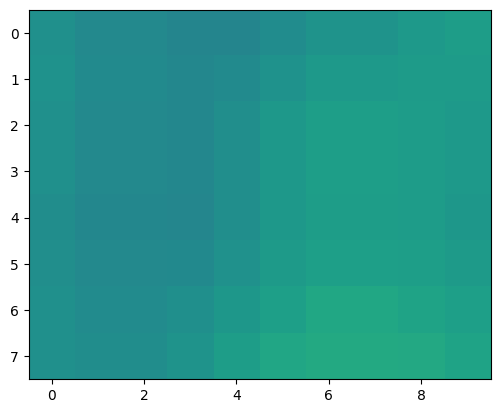

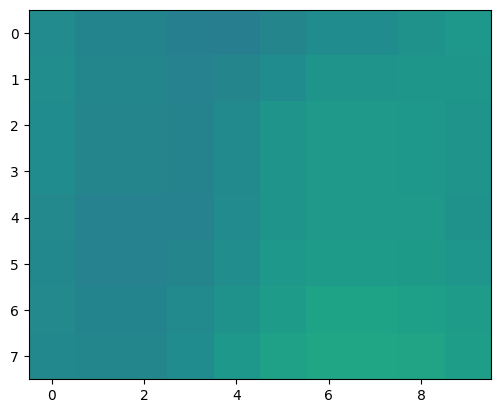

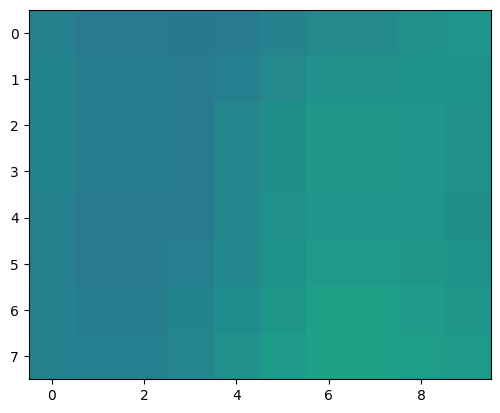

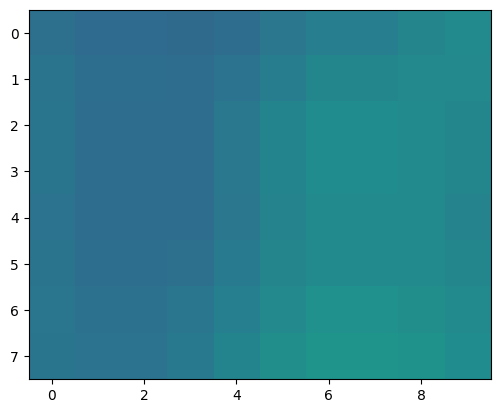

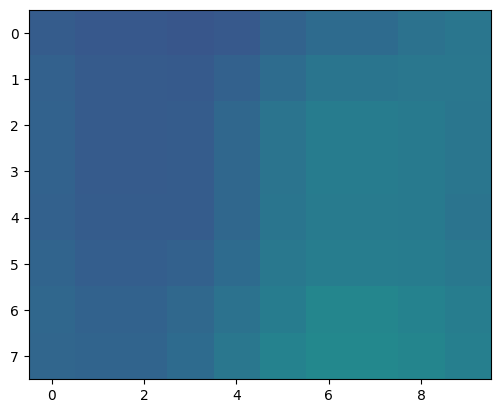

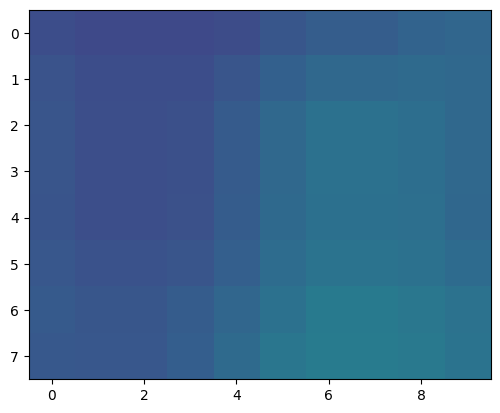

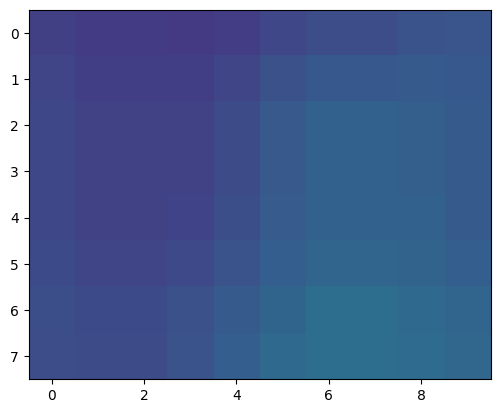

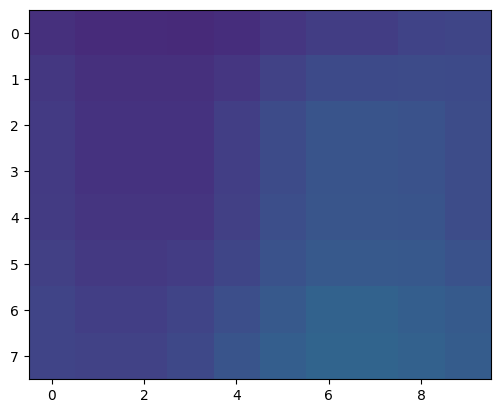

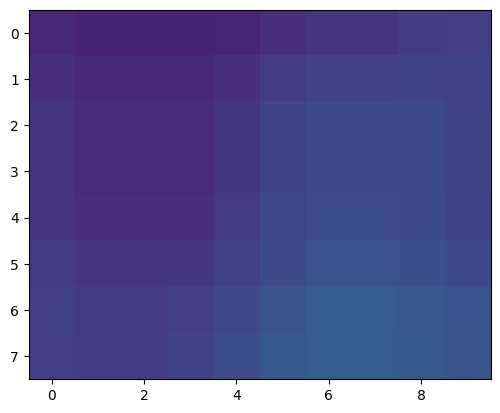

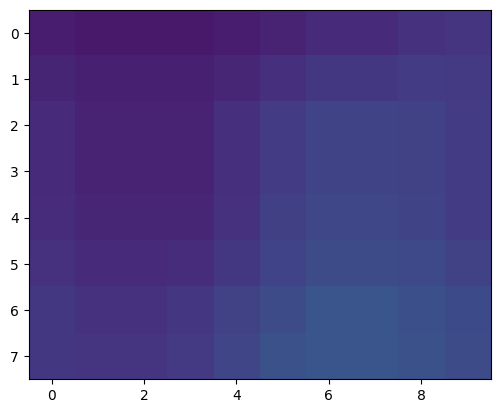

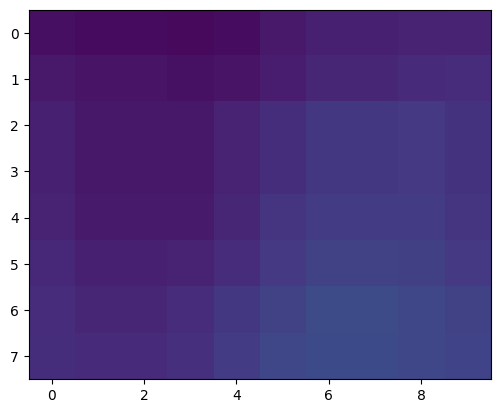

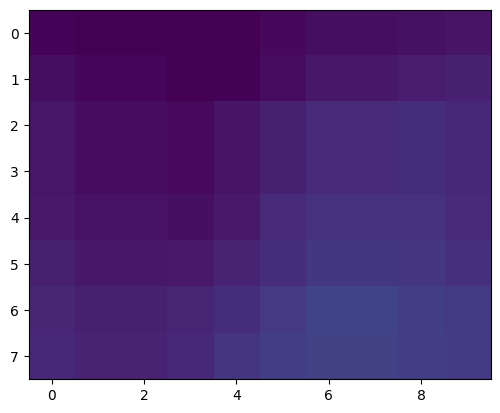

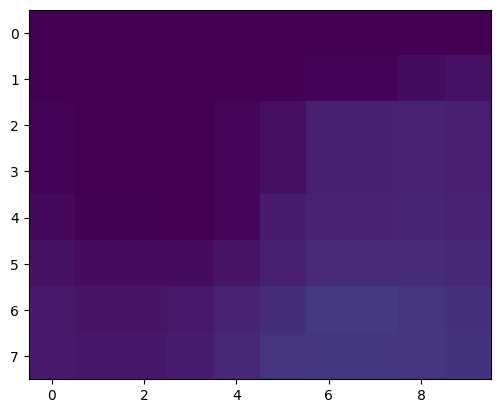

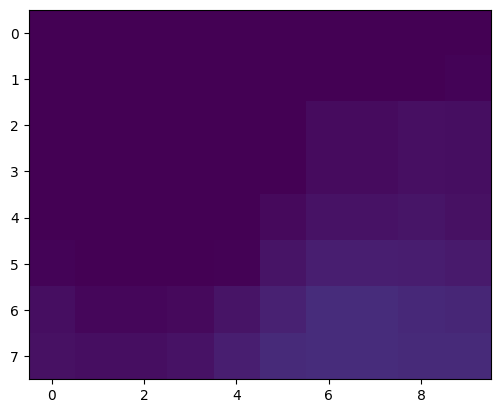

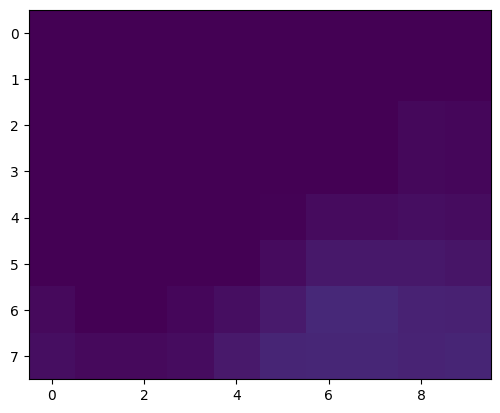

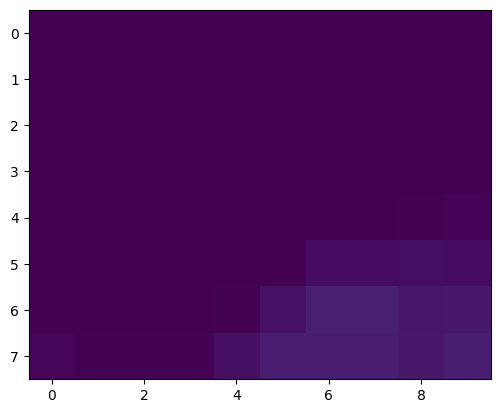

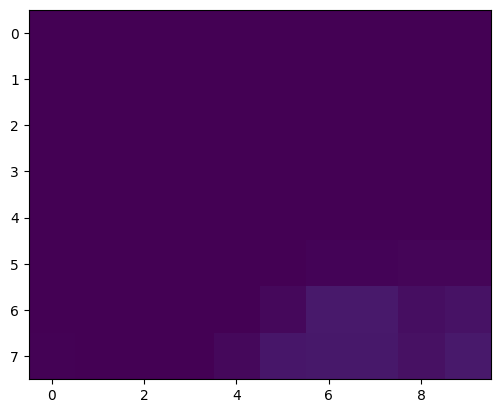

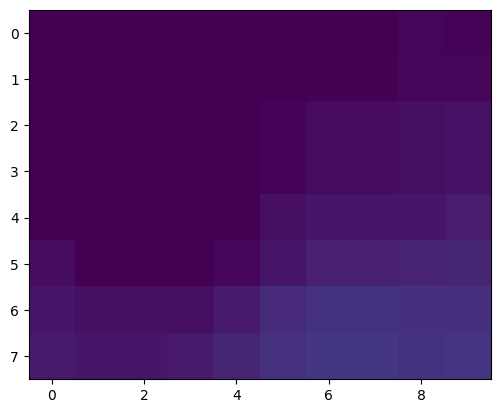

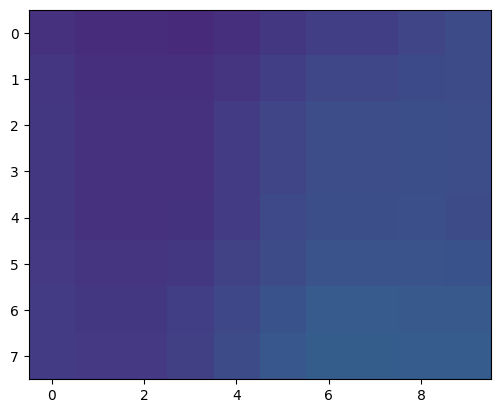

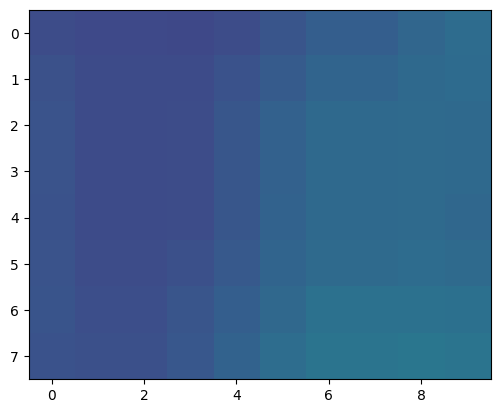

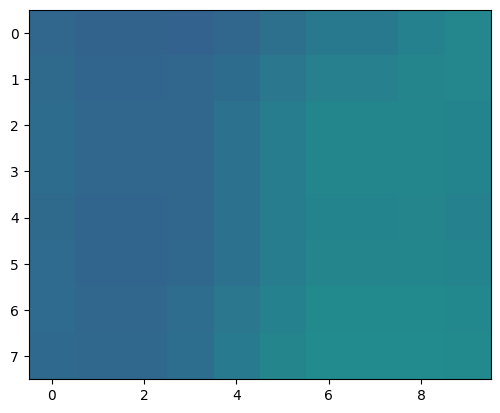

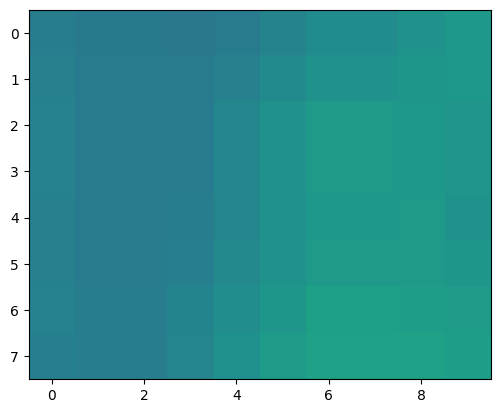

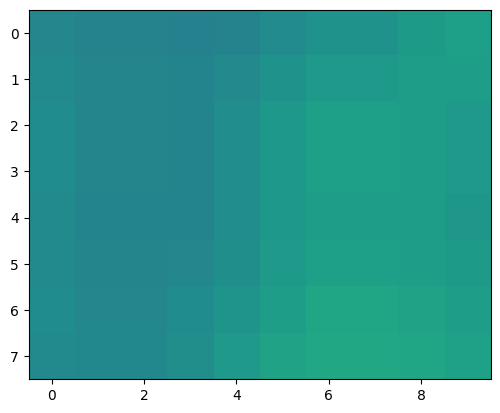

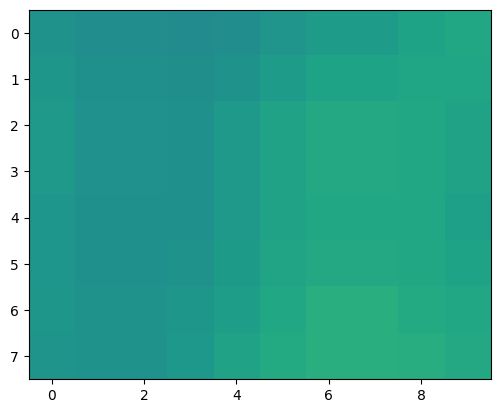

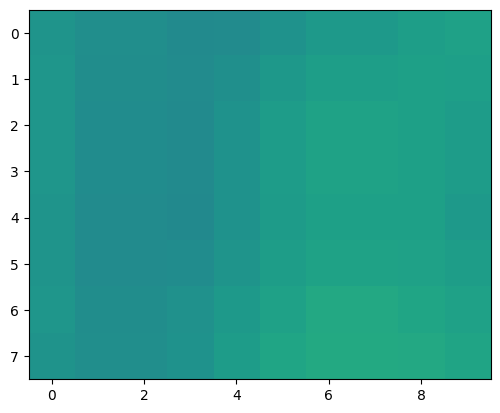

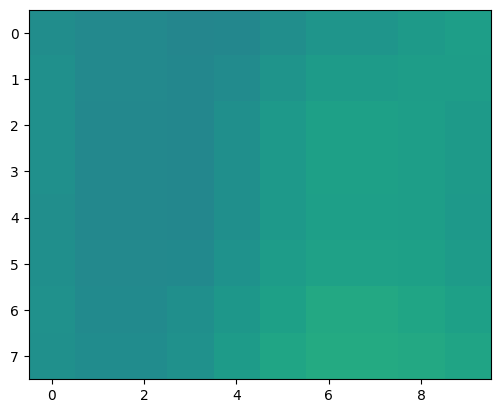

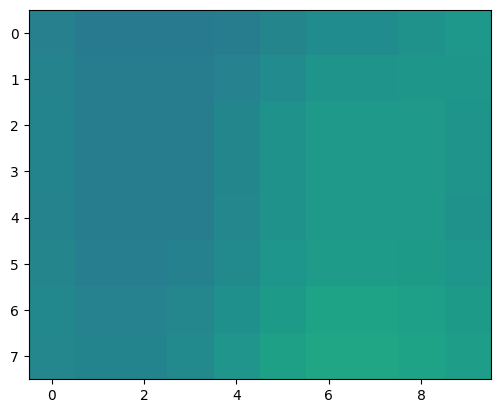

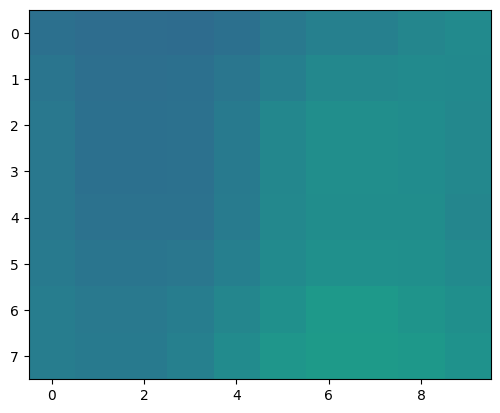

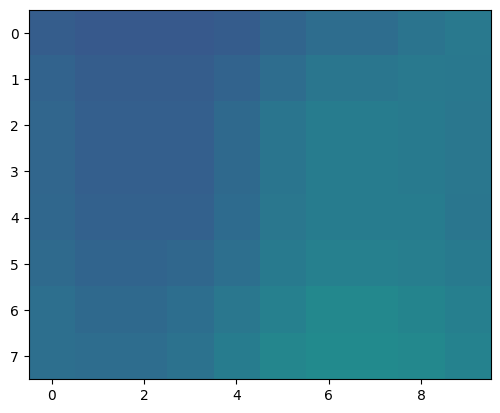

<Figure size 640x480 with 0 Axes>

In [347]:
#temp_series is the transpose of the src_data, so the
#temp_series plots we've been looking at are transposed.
#from normal orientation.

for frame in range(169):
    plt.figure()
    plt.imshow(temp_series.T[:,:,frame], cmap ='viridis', vmin=282, vmax = 297)
    plt.savefig(f"./temp_data_NWMass_9-18--9-25/frame_{frame}.png")
    plt.close()

So the "real" coordinates are (north-to-south, west-to-east)
Example, temp_series.T[0,0,:] are all the temperatures for the northwest
corner during the time period.
temp_series.T[1,0,:] is south, temp_series.T[0,1,:] is to the east. I hope.

In [348]:
#what were the "good" squares again?

In [393]:
corrs.drop('temp')

47    0.924208
39    0.924073
63    0.921412
55    0.921412
62    0.921408
        ...   
2     0.891809
8     0.887232
16    0.887232
1     0.886334
0     0.882967
Name: temp, Length: 80, dtype: float64

In [388]:
best_corrs

47    0.924208
39    0.924073
63    0.921412
55    0.921412
62    0.921408
54    0.921408
46    0.920389
31    0.920201
38    0.919472
61    0.919386
53    0.919386
69    0.918399
71    0.918197
70    0.917540
45    0.917511
Name: temp, dtype: float64

In [389]:
era5_temps.loc[47]

2024-09-18 01:00:00    293.946136
2024-09-18 02:00:00    292.980530
2024-09-18 03:00:00    291.954132
2024-09-18 04:00:00    290.966919
2024-09-18 05:00:00    290.400513
                          ...    
2024-09-24 22:00:00    290.499939
2024-09-24 23:00:00    289.852417
2024-09-25 00:00:00    288.889282
row                      4.000000
col                      7.000000
Name: 47, Length: 170, dtype: float64

In [367]:
square_mask

square
0     False
1     False
2     False
3     False
4     False
      ...  
75    False
76    False
77    False
78    False
79    False
Length: 80, dtype: bool

In [430]:
era5_temps

,2024-09-18 01:00:00,2024-09-18 02:00:00,2024-09-18 03:00:00,2024-09-18 04:00:00,2024-09-18 05:00:00,2024-09-18 06:00:00,2024-09-18 07:00:00,2024-09-18 08:00:00,2024-09-18 09:00:00,2024-09-18 10:00:00,...,2024-09-24 17:00:00,2024-09-24 18:00:00,2024-09-24 19:00:00,2024-09-24 20:00:00,2024-09-24 21:00:00,2024-09-24 22:00:00,2024-09-24 23:00:00,2024-09-25 00:00:00,row,col
square,,,,,,,,,,,,,,,,,,,,,
0,293.252777,291.494202,290.795929,290.603638,290.357544,289.751709,289.180359,287.658997,287.265289,287.099640,...,288.273254,288.949097,289.661743,289.741669,289.381348,288.515564,287.553589,286.418579,0,0
1,293.340668,292.078186,291.534210,291.132935,290.966919,290.314209,289.721375,288.201965,287.689117,287.285187,...,288.542786,289.197144,289.927368,289.886200,289.541504,288.726501,287.842651,286.754517,0,1
2,292.994965,292.343811,291.782257,290.968872,290.863403,290.212646,289.473328,287.858215,287.099274,286.339874,...,288.652161,289.288940,290.030884,289.876434,289.549316,288.794861,287.996948,286.949829,0,2
3,292.994965,292.343811,291.782257,290.968872,290.863403,290.212646,289.473328,287.858215,287.099274,286.339874,...,288.652161,289.288940,290.030884,289.876434,289.549316,288.794861,287.996948,286.949829,0,3
4,292.700043,292.113342,291.245148,290.230591,290.170044,289.972412,289.391296,287.905090,286.915680,285.732452,...,288.531067,289.152222,289.890259,289.747528,289.434082,288.728455,287.994995,286.986938,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,294.377777,292.543030,291.889679,290.691528,289.496216,288.552490,288.031921,288.926575,288.489899,287.716827,...,289.839661,290.117065,290.659790,290.290497,290.152832,289.755798,288.994995,287.932251,7,5
76,293.719574,292.521545,291.368195,290.728638,289.808716,288.511475,287.682312,288.840637,288.370758,287.878937,...,289.718567,289.956909,290.489868,290.134247,290.029785,289.656189,288.912964,287.883423,7,6
77,293.840668,292.865295,291.893585,290.921997,290.144653,289.460693,288.520203,289.035950,288.556305,288.011749,...,289.945129,290.158081,290.675415,290.331512,290.258301,289.890564,289.161011,288.151001,7,7


In [470]:
#plot the correlations by square.

corrs[1:]

square_corrs = np.zeros((8,10))

for row in range(8):
    for col in range(10):
        #get the square number with this row and column
        square_mask = (era5_temps['row'] == row) & (era5_temps['col'] == col)
        this_square_no = era5_temps[square_mask].index[0]
        print(f"row {row}, col {col}, square {this_square_no}")
        square_corrs[row,col] = corrs[this_square_no]

plt.imshow(square_corrs)

row 0, col 0, square 0
row 0, col 1, square 1
row 0, col 2, square 2
row 0, col 3, square 3
row 0, col 4, square 4
row 0, col 5, square 5
row 0, col 6, square 6
row 0, col 7, square 7


IndexError: index 0 is out of bounds for axis 0 with size 0

In [448]:
plt.imshow(era5_temps[np.array(corrs.drop('temp').index, dtype=int)].reshape((8,10)))

KeyError: "None of [Index([47, 39, 63, 55, 62, 54, 46, 31, 38, 61, 53, 69, 71, 70, 45, 51, 50, 59,\n       58, 52, 60, 68, 30, 44, 37, 43, 42, 79, 77, 66, 67, 57, 49, 15, 23, 36,\n       29, 76, 41, 78, 35, 34, 65, 14, 22, 75, 74, 28, 33, 73, 21, 13, 56, 48,\n       40, 64, 27, 26,  7, 72, 20, 12, 25, 32,  6, 19, 11, 10, 18,  5, 24,  4,\n       17,  9,  3,  2,  8, 16,  1,  0],\n      dtype='int32')] are in the [columns]"

In [451]:
corrs.drop('temp').index.astype(int)

Index([47, 39, 63, 55, 62, 54, 46, 31, 38, 61, 53, 69, 71, 70, 45, 51, 50, 59,
       58, 52, 60, 68, 30, 44, 37, 43, 42, 79, 77, 66, 67, 57, 49, 15, 23, 36,
       29, 76, 41, 78, 35, 34, 65, 14, 22, 75, 74, 28, 33, 73, 21, 13, 56, 48,
       40, 64, 27, 26,  7, 72, 20, 12, 25, 32,  6, 19, 11, 10, 18,  5, 24,  4,
       17,  9,  3,  2,  8, 16,  1,  0],
      dtype='int32')

In [453]:
era5_temps.loc[corrs.drop('temp').index]

,2024-09-18 01:00:00,2024-09-18 02:00:00,2024-09-18 03:00:00,2024-09-18 04:00:00,2024-09-18 05:00:00,2024-09-18 06:00:00,2024-09-18 07:00:00,2024-09-18 08:00:00,2024-09-18 09:00:00,2024-09-18 10:00:00,...,2024-09-24 17:00:00,2024-09-24 18:00:00,2024-09-24 19:00:00,2024-09-24 20:00:00,2024-09-24 21:00:00,2024-09-24 22:00:00,2024-09-24 23:00:00,2024-09-25 00:00:00,row,col
47,293.946136,292.980530,291.954132,290.966919,290.400513,289.749756,288.944031,288.276184,287.112946,286.628937,...,290.202942,290.646362,291.187134,290.819794,290.832520,290.499939,289.852417,288.889282,4,7
39,293.619965,292.628967,291.577179,290.625122,289.877075,289.083740,288.397156,287.366028,286.538727,286.177765,...,289.544739,290.056519,290.628540,290.274872,290.240723,289.849548,289.231323,288.303345,3,9
63,293.993011,293.023499,291.940460,290.951294,290.353638,289.829834,289.242859,289.157043,287.759430,286.906281,...,290.599426,290.964722,291.478149,291.120575,291.152832,290.843689,290.172729,289.184204,6,3
55,293.993011,293.023499,291.940460,290.951294,290.353638,289.829834,289.242859,289.157043,287.759430,286.906281,...,290.599426,290.964722,291.478149,291.120575,291.152832,290.843689,290.172729,289.184204,5,5
62,294.178558,293.023499,292.116241,291.037231,290.261841,289.288818,288.565125,289.323059,288.277008,286.193390,...,290.534973,290.859253,291.421509,291.026825,291.033691,290.728455,290.055542,289.024048,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,292.994965,292.343811,291.782257,290.968872,290.863403,290.212646,289.473328,287.858215,287.099274,286.339874,...,288.652161,289.288940,290.030884,289.876434,289.549316,288.794861,287.996948,286.949829,0,2
8,292.873871,291.369202,291.342804,290.730591,290.220825,289.544678,288.908875,287.596497,287.179352,286.992218,...,288.054504,288.687378,289.382446,289.384247,289.043457,288.249939,287.340698,286.213501,0,8
16,292.873871,291.369202,291.342804,290.730591,290.220825,289.544678,288.908875,287.596497,287.179352,286.992218,...,288.054504,288.687378,289.382446,289.384247,289.043457,288.249939,287.340698,286.213501,1,6
1,293.340668,292.078186,291.534210,291.132935,290.966919,290.314209,289.721375,288.201965,287.689117,287.285187,...,288.542786,289.197144,289.927368,289.886200,289.541504,288.726501,287.842651,286.754517,0,1
